# Facebook Data Crawling

## Craw Data

### Install The Required Library

In [ ]:
# Cài đặt thư viện dùng cho việc kéo dữ liệu từ facebook
%pip install facebook_scraper pandas numpy

# Import các thư viện cần thiết dùng cho quá trình kéo dữ liệu
from facebook_scraper import get_posts
import pandas as pd
import numpy as np
import time

### Extracting data from Facebook

In [ ]:
# Fanpage information
FANPAGE_LINK = "ThoBayMau"
FOLDER_PATH = "/Data"
COOKIE_PATH = "www.facebook.com_cookies.txt"
PAGES_NUMBER = 200  # Set the maximum page number to 140

# Proceed with data extraction
post_list = []
start_post = 113
end_post = PAGES_NUMBER

current_post = 1

for post in get_posts(FANPAGE_LINK,
                      options={"comments": True, "reactions": True, "allow_extra_requests": True},
                      extra_info=True, pages=PAGES_NUMBER, cookies=COOKIE_PATH):
    
    # Vì dữ liệu sẽ bị khuyết khi crawl nó quá nhanh nên sẽ cho request dừng 5(s) với mỗi post đã crawled => Hạn chế được việc crawl dữ liệu thiếu
    if current_post < start_post:
        current_post += 1
        time.sleep(5)
        continue
        
    if start_post <= current_post <= end_post:
        print(post)
        post_list.append(post)
        
    if current_post  == end_post:
        break
        
    current_post += 1

### Storing the crawled data

In [ ]:
# Initialize dataframe to scrape Facebook post
post_df_full = pd.DataFrame(columns=post_list[0].keys(), index=range(len(post_list)), data=post_list)

# To df
path=FOLDER_PATH + FANPAGE_LINK + ".csv"
post_df_full.to_csv(path, index=False)
print(path)

## Analyze Data

### Include the necessary libraries for analysis and read data

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import hashlib
import ast
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import random
from ast import literal_eval

In [22]:
from selenium import webdriver
from time import sleep
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from facebook_scraper import get_posts, get_profile
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
from ast import literal_eval
import numpy as np
import csv
import os
import re

In [23]:
read_df = pd.read_csv('Data/ThoBayMau.csv')

### Data preprocessing

In [24]:
# Nhìn sơ lược dữ liệu đã được crawl về
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   post_id                        122 non-null    int64  
 1   text                           122 non-null    object 
 2   post_text                      122 non-null    object 
 3   shared_text                    5 non-null      object 
 4   original_text                  0 non-null      float64
 5   time                           122 non-null    object 
 6   timestamp                      122 non-null    int64  
 7   image                          89 non-null     object 
 8   image_lowquality               119 non-null    object 
 9   images                         122 non-null    object 
 10  images_description             122 non-null    object 
 11  images_lowquality              122 non-null    object 
 12  images_lowquality_description  122 non-null    obj

#### Remove columns with complete null data

In [25]:
read_df = read_df.dropna(axis='columns', how='all')

In [26]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   post_id                        122 non-null    int64  
 1   text                           122 non-null    object 
 2   post_text                      122 non-null    object 
 3   shared_text                    5 non-null      object 
 4   time                           122 non-null    object 
 5   timestamp                      122 non-null    int64  
 6   image                          89 non-null     object 
 7   image_lowquality               119 non-null    object 
 8   images                         122 non-null    object 
 9   images_description             122 non-null    object 
 10  images_lowquality              122 non-null    object 
 11  images_lowquality_description  122 non-null    object 
 12  video                          13 non-null     obj

#### Handle columns with over 50% missing data

In [27]:
# Tính tỷ lệ giá trị null cho mỗi cột
Null_Percentage = read_df.isnull().mean()

# Lấy các cột có tỷ lệ giá trị null lớn hơn 50%
Null_Percentage[Null_Percentage > 0.5].index

Index(['shared_text', 'video', 'video_id', 'video_thumbnail', 'likes', 'link',
       'shared_post_id', 'shared_time', 'shared_user_id', 'shared_username',
       'shared_post_url', 'with'],
      dtype='object')

In [28]:
read_df['shared_text'].dropna().head(200)

45    VTV9 - Nhịp Sống Phương Nam\n11 tháng 2 lúc 19...
51    VIETCETERA.COM\nHuỳnh Thái Ngọc kể chuyện mượn...
59               Én\n21 tháng 1 lúc 23:47 ·\n\ntết buồn
64    YOUTUBE.COM\nTHỎ BẢY MÀU - THẦN BÀI MIỀN TÂY |...
94       YOUTUBE.COM\n[Teaser] Series HOẠT HÌNH CON THỎ
Name: shared_text, dtype: object

In [29]:
read_df['video'].dropna().head(200)

# Kiểm tra chất lượng của các đường link
check = False
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
for index, row in read_df.iterrows():
    link = row['video']
    
    if pd.notna(link):
        try:
            response = requests.get(link)
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()
            
            if response.status_code == 200 and sha256_hash == expected_hash_value:
                check = True
            else:
                read_df.loc[index, 'video'] = np.nan
        except requests.ConnectionError:
            read_df.loc[index, 'video'] = np.nan

# Kiểm tra chất đường link sau khi kiểm tra
print(check)
read_df['video'].dropna().head(200)
read_df = read_df.drop(columns = 'video')

False


In [30]:
read_df['video_id'].dropna().head(200)

# Dữ liệu ở cột này không có giá trị phân tích => Cột này sẽ bị xóa
read_df = read_df.drop(columns = 'video_id')

In [31]:
read_df['video_thumbnail'].dropna().head(200)

# Kiểm tra chất lượng của các đường link
check = False
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
for index, row in read_df.iterrows():
    link = row['video_thumbnail']
    
    if pd.notna(link):
        try:
            response = requests.get(link)
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()
            
            if response.status_code == 200 and sha256_hash == expected_hash_value:
                check = True
            else:
                read_df.loc[index, 'video_thumbnail'] = np.nan
        except requests.ConnectionError:
            read_df.loc[index, 'video_thumbnail'] = np.nan
            
# Kiểm tra lại chất lượng đường link sau khi kiểm tra
print(check)
read_df['video_thumbnail'].dropna().head(200)
read_df = read_df.drop(columns = 'video_thumbnail')

False


In [32]:
read_df['likes'].dropna().head(200)

# Dữ liệu không có giá trị phân tích => Cột này bị xóa bỏ
read_df = read_df.drop(columns = 'likes')

In [33]:
read_df['link'].dropna().head(200)

# Kiểm tra chất lượng của các đường link
# Kiểm tra chất lượng của các đường link
check = False
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
for index, row in read_df.iterrows():
    link = row['link']
    
    if pd.notna(link):
        try:
            response = requests.get(link)
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()
            
            if response.status_code == 200 and sha256_hash == expected_hash_value:
                check = True
            else:
                read_df.loc[index, 'link'] = np.nan
        except requests.ConnectionError:
            read_df.loc[index, 'link'] = np.nan
            
# Kiểm tra lại chất lượng đường link sau khi kiểm tra
print(check)
read_df['link'].dropna().head(200)
read_df = read_df.drop(columns = 'link')

False


In [34]:
read_df['shared_post_id'].dropna().head(200)

# Dữ liệu không có giá trị phân tích
# => Cột này bị xóa
read_df = read_df.drop(columns = 'shared_post_id')

In [35]:
read_df['shared_time'].dropna().head(200)

# => Các giá trị còn lại có thể ảnh hưởng, tạo ra một số điểm kỳ dị, bất thường ở chỉ số tương tác nên giữ lại

45    2023-02-11 19:43:00
59    2023-01-21 23:47:00
Name: shared_time, dtype: object

In [36]:
read_df['shared_user_id'].dropna().head(200)

# Dữ liệu không có giá trị phân tích
# => Cột này bị xóa
read_df = read_df.drop(columns = 'shared_user_id')

In [37]:
read_df['shared_username'].dropna().head(200)

# Loại bỏ cột này đi
read_df = read_df.drop(columns = 'shared_username')

In [38]:
read_df['shared_post_url'].dropna().head(200)

# Kiểm tra thủ công hai đường link
# => Đường link không thể truy cập
# => Cột này sẽ bị xóa đi
read_df = read_df.drop(columns = 'shared_post_url')

In [39]:
read_df['with'].dropna().head(200)

# Loại bỏ cột này
read_df = read_df.drop(columns='with')

#### Process the remaining data

In [40]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   post_id                        122 non-null    int64  
 1   text                           122 non-null    object 
 2   post_text                      122 non-null    object 
 3   shared_text                    5 non-null      object 
 4   time                           122 non-null    object 
 5   timestamp                      122 non-null    int64  
 6   image                          89 non-null     object 
 7   image_lowquality               119 non-null    object 
 8   images                         122 non-null    object 
 9   images_description             122 non-null    object 
 10  images_lowquality              122 non-null    object 
 11  images_lowquality_description  122 non-null    object 
 12  comments                       122 non-null    int

In [41]:
read_df['post_id'].head(200)

0       887500939607306
1       880092607014806
2       873217404368993
3       872828461074554
4       871559354534798
             ...       
117    5779111968766066
118    5774334629243800
119    5771773926166537
120    5771649009512362
121    5768398723170724
Name: post_id, Length: 122, dtype: int64

In [42]:
# Kiểm tra giả thuyết cột text sẽ bằng dữ liệu cột post_text nối tiếp bởi cột shared_text(nếu có)
check = True
for index, row in read_df.iterrows():
    if pd.notna(row['shared_text']):
        if row['text'] != (row['post_text'] + "\n\n" + row['shared_text']):
            check = False
    else:
        if row['text'] != row['post_text']:
            check = False

# Kiểm tra tính đúng đắn của giả thuyết sau khi kiểm tra
print(check)

# Dữ liệu cột text sẽ bị xóa đi và dữ lại hai cột còn lại
read_df = read_df.drop(columns = 'text')

True


In [43]:
read_df['time'].dropna().head(200)
read_df['timestamp'].dropna().head(200)

# Vì dữ liệu của timestamp chính là giá trị của cột time tính đến thời điểm nhất định được tính bằng (s)
# => Có thể xóa cột timestamp đi
read_df = read_df.drop(columns = 'timestamp')

In [44]:
read_df['image'].dropna().head(200)

# Kiểm tra chất lượng của các đường link
check = False
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
for index, row in read_df.iterrows():
    link = row['image']
    
    if pd.notna(link):
        try:
            response = requests.get(link)
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()
            
            if response.status_code == 200 and sha256_hash == expected_hash_value:
                check = True
            else:
                read_df.loc[index, 'image'] = np.nan
        except requests.ConnectionError:
            read_df.loc[index, 'image'] = np.nan
            
    
# Kiểm tra chất đường link sau khi kiểm tra
print(check)
read_df = read_df.drop(columns = 'image')

False


In [45]:
read_df['image_lowquality'].dropna().head(200)

# Kiểm tra chất lượng của các đường link
check = False
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
for index, row in read_df.iterrows():
    link = row['image_lowquality']
    
    if pd.notna(link):
        try:
            response = requests.get(link)
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()
            
            if response.status_code == 200 and sha256_hash == expected_hash_value:
                check = True
            else:
                read_df.loc[index, 'image_lowquality'] = np.nan
        except requests.ConnectionError:
            read_df.loc[index, 'image_lowquality'] = np.nan

# Kiểm tra chất đường link sau khi kiểm tra
print(check)
read_df['image_lowquality'].dropna().head(200)
read_df = read_df.drop(columns = 'image_lowquality')

False


In [46]:
read_df['images'].dropna().head(200)

# Kiểm tra chất lượng của các đường link
check = False 
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
for index, row in read_df.iterrows():
    link = row['images']
    length_string = len(link)
    
    if length_string > 2:
        link = link[2:(length_string - 2)]
        
        if pd.notna(link):
            try:
                response = requests.get(link)
                sha256_hash = hashlib.sha256(link.encode()).hexdigest()
                
                if response.status_code == 200 and sha256_hash == expected_hash_value:
                    check = Truerue
                else:
                    read_df.loc[index, 'images'] = np.nan      
            except requests.ConnectionError:
                read_df.loc[index, 'images'] = np.nan
    else:
        read_df.loc[index, 'images'] = np.nan

# Kiểm tra chất đường link sau khi kiểm tra        
print(check)
read_df = read_df.drop(columns = 'images')

False


In [47]:
read_df['images_description'].dropna().head(200)
read_df['images_description'].value_counts()

# Dữ liệu của cột này rất chung chung => Không có giá trị phân tích
read_df = read_df.drop(columns='images_description')

In [48]:
read_df['images_lowquality'].dropna().head(200)

# Kiểm tra chất lượng của các đường link
check = False 
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
for index, row in read_df.iterrows():
    link = row['images_lowquality']
    length_string = len(link)
    
    if length_string > 2:
        link = link[2:(length_string - 2)]
        
        if pd.notna(link):
            try:
                response = requests.get(link)
                sha256_hash = hashlib.sha256(link.encode()).hexdigest()
                
                if response.status_code == 200 and sha256_hash == expected_hash_value:
                    check = true
                else:
                    read_df.loc[index, 'images'] = np.nan      
            except requests.ConnectionError:
                read_df.loc[index, 'images'] = np.nan
    else:
        read_df.loc[index, 'images_lowquality'] = np.nan

#Kiểm tra chất đường link sau khi kiểm tra        
print(check)
read_df = read_df.drop(columns = 'images_lowquality')

False


In [49]:
read_df['images_lowquality_description'].dropna().head(200)
read_df['images_lowquality_description'].value_counts()

# Dữ liệu của cột này rất chung chung => Không có giá trị phân tích
read_df = read_df.drop(columns='images_lowquality_description')

In [50]:
read_df['comments'].dropna().head(200)

0      1440
1       897
2      3314
3       632
4      1071
       ... 
117       0
118       0
119       0
120       0
121       0
Name: comments, Length: 122, dtype: int64

In [51]:
read_df['shares'].dropna().head(200)

0      255
1      204
2      777
3      136
4      133
      ... 
117      0
118      0
119      0
120      0
121      0
Name: shares, Length: 122, dtype: int64

In [52]:
read_df['post_url'].dropna().head(200)

# Kiểm tra chất lượng của các đường link
check = False
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
for index, row in read_df.iterrows():
    link = row['post_url']

    if pd.notna(link):
        try:
            response = requests.get(link, timeout=10)
            response.raise_for_status()  # Check for HTTP errors
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()

            if response.status_code == 200 and sha256_hash == expected_hash_value:
                check = True
            else:
                read_df.loc[index, 'post_url'] = np.nan
        except requests.exceptions.ReadTimeout:
            read_df.loc[index, 'post_url'] = np.nan
        except requests.exceptions.RequestException as e:
            read_df.loc[index, 'post_url'] = np.nan

# Kiểm tra chất đường link sau khi kiểm tra
print(check)
read_df = read_df.drop(columns='post_url')

False


In [53]:
read_df['links'].dropna().head(200)

# Dữ liệu của cột chứa đường link dẫn tới bài viết có thể được thay thế bằng post_id
# => Xóa cột này đi

read_df = read_df.drop(columns='links')

In [54]:
read_df['user_id'].dropna().head(200)

# Kiểm tra đường link có dẫn tới một trang duy nhất không
check = True
for index, row in read_df.iterrows():
    link_id = row['user_id']
    full_link = "https://www.facebook.com" + "/" + str(link_id)
    
    try:
        response = requests.get(full_link)
        final_link = response.url
                  
        if (final_link == "https://www.facebook.com/ThoBayMau") or (final_link == "https://www.facebook.com/ThoBayMau/"):
                check = True
        else:
            check = False
    except requests.ConnectionError:
            check = False
                              
# Kiểm tra tính đúng đắn của giả thuyết => Không sinh ra điểm biến dị => Xóa cột này đi
print(check)
read_df = read_df.drop(columns = 'user_id')

True


In [55]:
read_df['username'].head(200)
read_df['username'].value_counts()

# Dữ liệu trùng khớp trên miền dữ liệu => Không nảy sinh điểm biến dị => Xóa cột này đi
read_df = read_df.drop(columns = 'username')

In [56]:
read_df['user_url'].dropna().head(200)

# Vì dữ liệu của cột này dẫn đến trang user đăng bài
# Vì người đăng là một => Cột này bị xóa

read_df = read_df.drop(columns='user_url')

In [57]:
read_df['is_live'].head(200)
read_df['is_live'].value_counts()

# Trường dữ liệu không có điểm biến dị => Xóa cột này
read_df = read_df.drop(columns = 'is_live')

In [58]:
read_df['shared_time'].dropna().head(200)

45    2023-02-11 19:43:00
59    2023-01-21 23:47:00
Name: shared_time, dtype: object

In [59]:
read_df['available'].dropna().head(200)
read_df['available'].value_counts()

# Dữ liệu trùng nhau ở mọi giá trị => Không tạo ra điểm đặc biệt => Cột này bị xóa
read_df = read_df.drop(columns='available')

In [60]:
read_df['comments_full'].dropna().head(200)

0      [{'comment_id': '341188248485143', 'comment_ur...
1      [{'comment_id': '253298627216485', 'comment_ur...
2      [{'comment_id': '1012903103360530', 'comment_u...
3      [{'comment_id': '1422555371635885', 'comment_u...
4      [{'comment_id': '10041502755891991', 'comment_...
                             ...                        
117                                                   []
118                                                   []
119                                                   []
120                                                   []
121                                                   []
Name: comments_full, Length: 122, dtype: object

In [62]:
read_df['w3_fb_url'].dropna().head(200)

# Kiểm tra chất lượng của các đường link 
check = False
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
for index, row in read_df.iterrows():
    link = row['w3_fb_url']
    
    if pd.notna(link):
        try:
            response = requests.get(link)
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()
            
            if response.status_code == 200 and sha256_hash == expected_hash_value:
                check = True
            else:
                read_df.loc[index, 'w3_fb_url'] = np.nan
        except requests.ConnectionError:
            read_df.loc[index, 'w3_fb_url'] = np.nan

# Kiểm tra chất đường link sau khi kiểm tra
print(check)
read_df = read_df.drop(columns='w3_fb_url')

False


In [63]:
read_df['reactions'].dropna().head(200)

0      {'thích': 9660, 'yêu thích': 1543, 'haha': 568...
1      {'thích': 24170, 'yêu thích': 728, 'haha': 955...
2      {'thích': 18492, 'yêu thích': 1203, 'haha': 27...
3      {'thích': 12069, 'yêu thích': 349, 'haha': 115...
4      {'thích': 11521, 'yêu thích': 307, 'haha': 137...
                             ...                        
106    {'thích': 9066, 'yêu thích': 134, 'haha': 9492...
107    {'thích': 23017, 'yêu thích': 432, 'haha': 137...
108    {'thích': 45832, 'yêu thích': 423, 'haha': 336...
109    {'thích': 10574, 'yêu thích': 155, 'haha': 110...
110    {'thích': 9050, 'yêu thích': 118, 'haha': 1126...
Name: reactions, Length: 110, dtype: object

In [64]:
read_df['reaction_count'].dropna().head(200)

0      17246
1      34711
2      47869
3      24156
4      25785
       ...  
117        0
118        0
119        0
120        0
121        0
Name: reaction_count, Length: 122, dtype: int64

In [65]:
read_df['page_id'].dropna().head(200)
read_df['page_id'].value_counts()

# Dữ liệu không có điểm đặc biệt => Xóa cột này đi
read_df = read_df.drop(columns='page_id')

In [66]:
read_df['image_id'].dropna().head(200)
read_df['image_id'].value_counts()

# Dữ liệu không trực quan => Xóa cột này đi
read_df = read_df.drop(columns='image_id')

In [68]:
read_df['was_live'].dropna().head(200)
read_df['was_live'].value_counts()

# Dữ liệu không có điểm dị biệt nên xóa cột này đi
read_df = read_df.drop(columns='was_live')

In [69]:
read_df['fetched_time'].dropna().head(200)

# Trường dữ liệu chỉ chứa thời gian dữ liệu được kéo về => Xóa cột này đi vì không có tác dụng phân tích
read_df = read_df.drop(columns='fetched_time')

#### Data verification

In [123]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, 0 to 110
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   post_id        110 non-null    int64         
 1   post_text      110 non-null    object        
 2   shared_text    5 non-null      object        
 3   time           110 non-null    datetime64[ns]
 4   shared_time    2 non-null      object        
 5   comments_full  110 non-null    object        
 6   reactors       35 non-null     object        
 7   reactions      110 non-null    object        
 8   image_ids      84 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 12.7+ KB


In [61]:
read_df['reactors'].dropna().head(200)
read_df['reactors'].replace("[]", np.nan, inplace=True)

In [67]:
read_df['image_ids'].dropna().head(200)

# Chuyển tất cả các giá trị không có ảnh thành null
read_df['image_ids'].replace("[]", np.nan, inplace=True)
read_df['image_ids'].value_counts()

image_ids
['887494852941248']     1
['6207505969259995']    1
['6223228554354403']    1
['6233804503296808']    1
['6237247292952529']    1
                       ..
['6628020390541882']    1
['6640067969337124']    1
['6644433798900541']    1
['6673825535961367']    1
['5768397336504196']    1
Name: count, Length: 91, dtype: int64

In [71]:
# Xóa đi các dòng dữ liệu bị lỗi
read_df['reactions'].dropna().head(200)

read_df = read_df.loc[read_df['reactions'].notna()]

# Chuyển dữ liệu thành từ điển
read_df['reactions'] = read_df['reactions'].apply(ast.literal_eval)

# Thêm trường dữ liệu của comments và shares vào mục reactions
def process_row(row):
    reactions_dict = row['reactions']
    reactions_dict["shares"] = row['shares']
    reactions_dict["comments"] = row['comments']
    return reactions_dict

processed_df = read_df.apply(process_row, axis=1)

result_df = pd.DataFrame(processed_df.tolist())

final_df = pd.concat([read_df, result_df], axis=1)

# Xóa dữ liệu ở trường comments, shares, reaction_count
read_df = read_df.drop(columns="shares")
read_df = read_df.drop(columns="comments")
read_df = read_df.drop(columns="reaction_count")

In [72]:
# Dữ liệu của cột images vẫn chưa được xóa dù đã đánh giá => Xóa cột này

read_df = read_df.drop(columns='images')

In [73]:
read_df['time'] = pd.to_datetime(read_df['time'])

### Data Analysis

#### The article with the highest engagement

In [75]:
read_df_test = read_df.copy()

In [76]:
read_df_test['total_reactions'] = read_df_test['reactions'].apply(lambda x: sum(x.values()))

In [77]:
read_df_test['total_reactions'].idxmax()

33

In [124]:
read_df_test.iloc[33]

post_id                                           6538090046201584
post_text        Chính thức khánh thành công trình cầu cá tra 2...
shared_text                                                    NaN
time                                           2023-02-27 13:21:47
shared_time                                                    NaN
comments_full    [{'comment_id': '5655823904526854', 'comment_u...
reactors         [{'name': 'Như Như', 'link': 'https://facebook...
reactions        {'thích': 157837, 'yêu thích': 4064, 'haha': 2...
image_ids                                     ['6538061922871063']
Name: 33, dtype: object

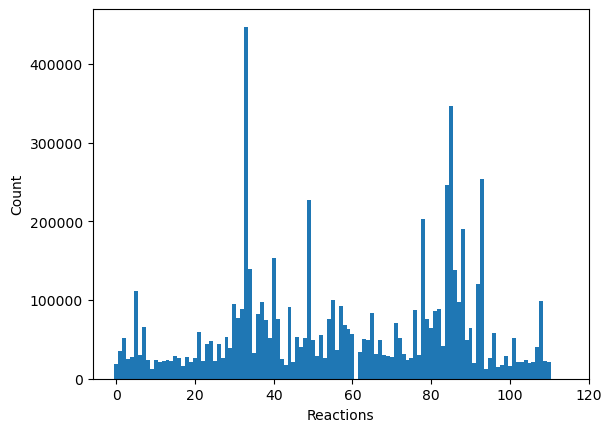

<Figure size 1400x800 with 0 Axes>

In [79]:
plt.bar(read_df_test.index, read_df_test['total_reactions'], 1, label='total_reactions')

plt.xlabel("Reactions")
plt.ylabel("Count")

custom_ticks = [0, 20, 40, 60, 80, 100, 120]
plt.xticks(custom_ticks)
plt.figure(figsize=(14, 8))

plt.show()

In [80]:
first_value = read_df_test['reactions'].apply(lambda x: next(iter(x.values())))

second_value = read_df_test['reactions'].apply(lambda x: list(x.values())[1] if len(x.values()) > 1 else None)

third_value = read_df_test['reactions'].apply(lambda x: list(x.values())[2] if len(x.values()) > 2 else None)

fourth_value = read_df_test['reactions'].apply(lambda x: list(x.values())[3] if len(x.values()) > 3 else None)

fifth_value = read_df_test['reactions'].apply(lambda x: list(x.values())[4] if len(x.values()) > 4 else None)

sixth_value = read_df_test['reactions'].apply(lambda x: list(x.values())[5] if len(x.values()) > 5 else None)

seventh_value = read_df_test['reactions'].apply(lambda x: list(x.values())[6] if len(x.values()) > 6 else None)

eighth_value = read_df_test['reactions'].apply(lambda x: list(x.values())[7] if len(x.values()) > 7 else None)

ninth_value = read_df_test['reactions'].apply(lambda x: list(x.values())[8] if len(x.values()) > 8 else None)

index = read_df_test.index

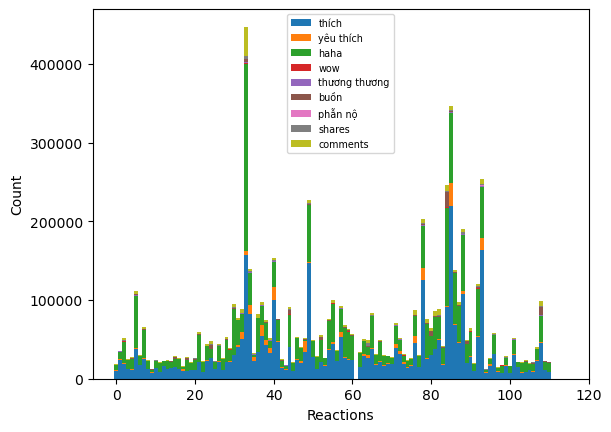

<Figure size 1400x800 with 0 Axes>

In [81]:
plt.bar(index, first_value, 1, label="thích")

plt.bar(index, second_value, 1,bottom=first_value, label="yêu thích")

b_third_value = list(np.add(first_value, second_value))
plt.bar(index, third_value, 1,bottom=b_third_value, label="haha")

b_fourth_value = list(np.add(b_third_value, third_value))
plt.bar(index, fourth_value, 1, bottom=b_fourth_value, label="wow")

b_fifth_value = list(np.add(b_fourth_value, fourth_value))
plt.bar(index, fifth_value, 1, bottom=b_fifth_value, label="thương thương")

b_sixth_value = list(np.add(b_fifth_value, fifth_value))
plt.bar(index, sixth_value, 1, bottom=b_sixth_value, label="buồn")

b_seventh_value = list(np.add(b_sixth_value, sixth_value))
plt.bar(index, seventh_value, 1, bottom=b_seventh_value, label="phẫn nộ")

b_eight_value = list(np.add(b_seventh_value, seventh_value))
plt.bar(index, eighth_value, 1, bottom=b_eight_value, label="shares")

b_ninth_value = list(np.add(b_eight_value, eighth_value))
plt.bar(index, ninth_value, 1, bottom=b_ninth_value, label="comments")

plt.xlabel("Reactions")
plt.ylabel("Count")
plt.legend(fontsize='x-small')

custom_ticks = [0, 20, 40, 60, 80, 100, 120]
plt.xticks(custom_ticks)
plt.figure(figsize=(14, 8))

plt.show()

#### Analysis of posting time

In [82]:
read_df_test = read_df.copy()

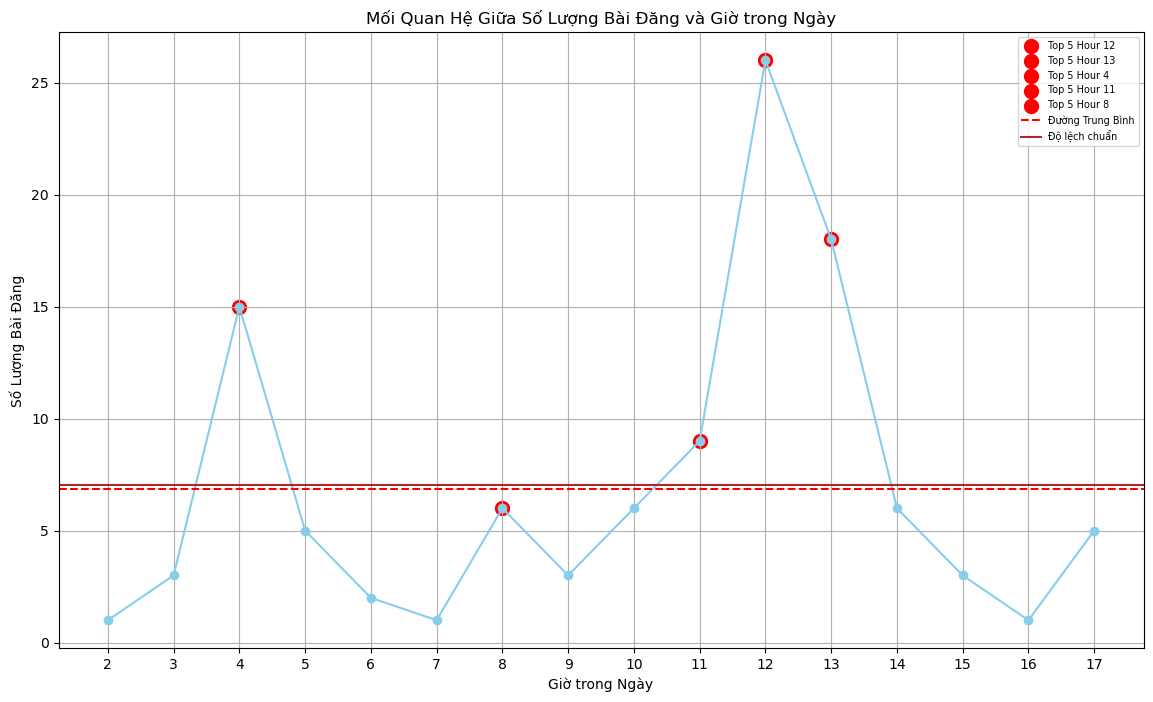

In [125]:
read_df_test['hour'] = read_df_test['time'].dt.hour

hourly_post_count = read_df_test['hour'].value_counts().sort_index()

mean_post_count = hourly_post_count.mean()
std_post_count = hourly_post_count.std()

# Get top 5 hours
top_hours = hourly_post_count.nlargest(5).index

plt.figure(figsize=(14, 8))

# Plot the hourly post count
plt.plot(hourly_post_count.index, hourly_post_count.values, marker='o', linestyle='-', color='skyblue')

# Highlight top 5 hours with markers and labels
for hour in top_hours:
    plt.scatter(hour, hourly_post_count[hour], color='red', marker='o', s=100, label=f'Top 5 Hour {hour}')

plt.axhline(mean_post_count, color='red', linestyle='--', label='Đường Trung Bình')
plt.axhline(std_post_count, color='brown', linestyle='-', label='Độ lệch chuẩn')

plt.xlabel('Giờ trong Ngày')
plt.ylabel('Số Lượng Bài Đăng')
plt.title('Mối Quan Hệ Giữa Số Lượng Bài Đăng và Giờ trong Ngày')
plt.xticks(hourly_post_count.index)
plt.grid(True)
plt.legend(fontsize='x-small')

plt.show()

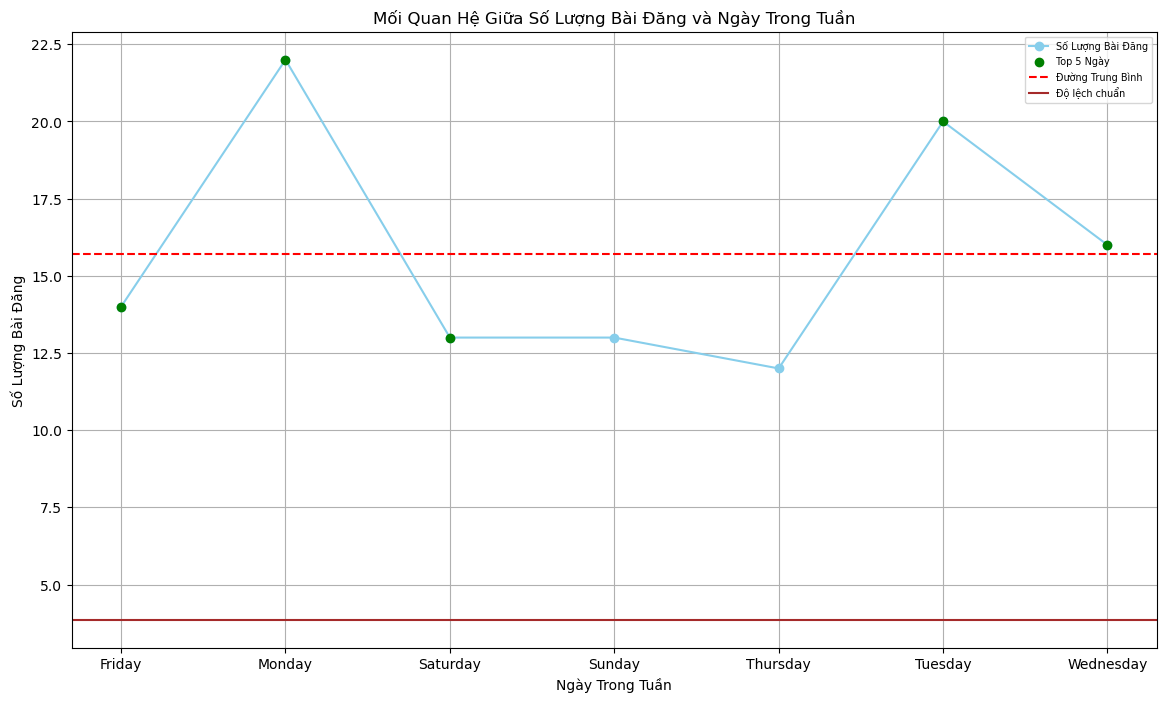

In [129]:
read_df_test['day_of_week'] = read_df_test['time'].dt.day_name()

day_post_count = read_df_test['day_of_week'].value_counts().sort_index()

mean_post_count = day_post_count.mean()
std_post_count = day_post_count.std()

# Get the top 5 days
top_5_days = day_post_count.nlargest(5).index

plt.figure(figsize=(14, 8))
plt.plot(day_post_count.index, day_post_count.values, marker='o', linestyle='-', color='skyblue', label='Số Lượng Bài Đăng')
plt.scatter(top_5_days, day_post_count[top_5_days], color='green', label='Top 5 Ngày', zorder=5)  # Add zorder to make sure scatter points are on top

plt.axhline(mean_post_count, color='red', linestyle='--', label='Đường Trung Bình')
plt.axhline(std_post_count, color='brown', linestyle='-', label='Độ lệch chuẩn')

plt.xlabel('Ngày Trong Tuần')
plt.ylabel('Số Lượng Bài Đăng')
plt.title('Mối Quan Hệ Giữa Số Lượng Bài Đăng và Ngày Trong Tuần')
plt.xticks(day_post_count.index)
plt.grid(True)
plt.legend(fontsize='x-small')

plt.show()

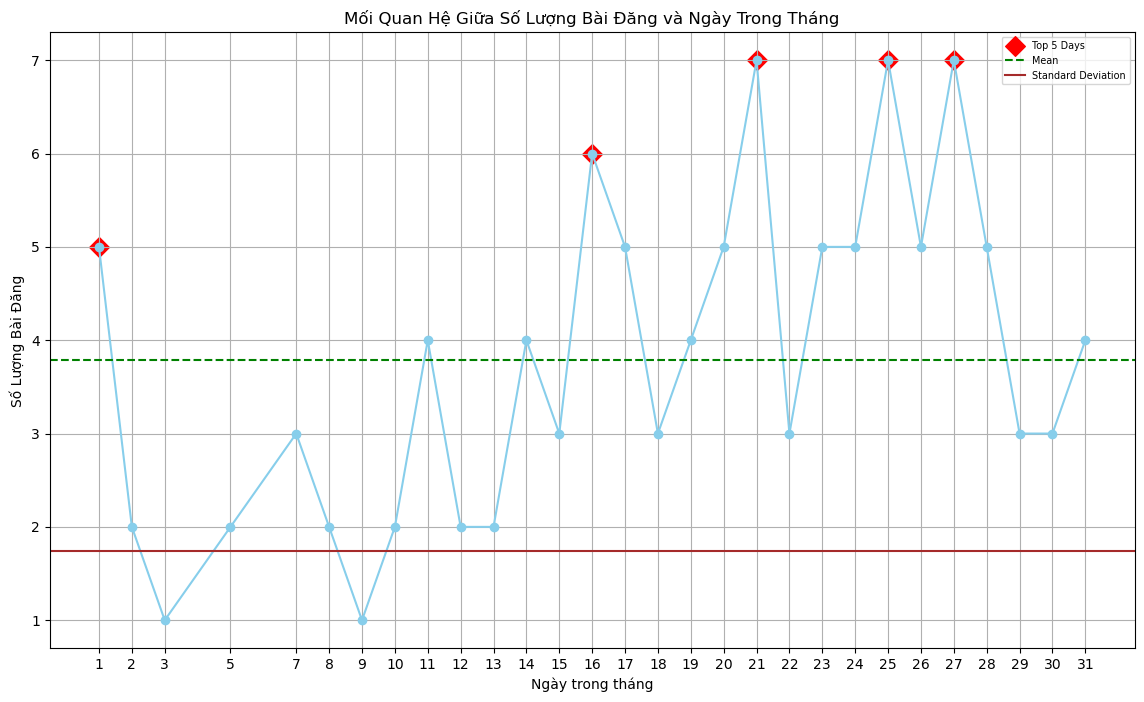

In [134]:
# Assuming 'time' is a datetime column in your DataFrame
read_df_test['day'] = read_df_test['time'].dt.day

# Count the number of posts per day
daily_post_count = read_df_test['day'].value_counts().sort_index()

# Get the top 5 days
top_5_days = daily_post_count.nlargest(5)

# Calculate mean and standard deviation
mean_post_count = daily_post_count.mean()
std_post_count = daily_post_count.std()

# Plot the data
plt.figure(figsize=(14, 8))
plt.plot(daily_post_count.index, daily_post_count.values, marker='o', linestyle='-', color='skyblue')

# Highlight the top 5 days with a different marker or color
plt.scatter(top_5_days.index, top_5_days.values, color='red', marker='D', s=100, label='Top 5 Days')

# Add mean and standard deviation lines
plt.axhline(mean_post_count, color='green', linestyle='--', label='Mean')
plt.axhline(std_post_count, color='brown', linestyle='-', label='Standard Deviation')

plt.xlabel('Ngày trong tháng')
plt.ylabel('Số Lượng Bài Đăng')
plt.title('Mối Quan Hệ Giữa Số Lượng Bài Đăng và Ngày Trong Tháng')
plt.xticks(daily_post_count.index)
plt.grid(True)
plt.legend(fontsize='x-small')

plt.show()

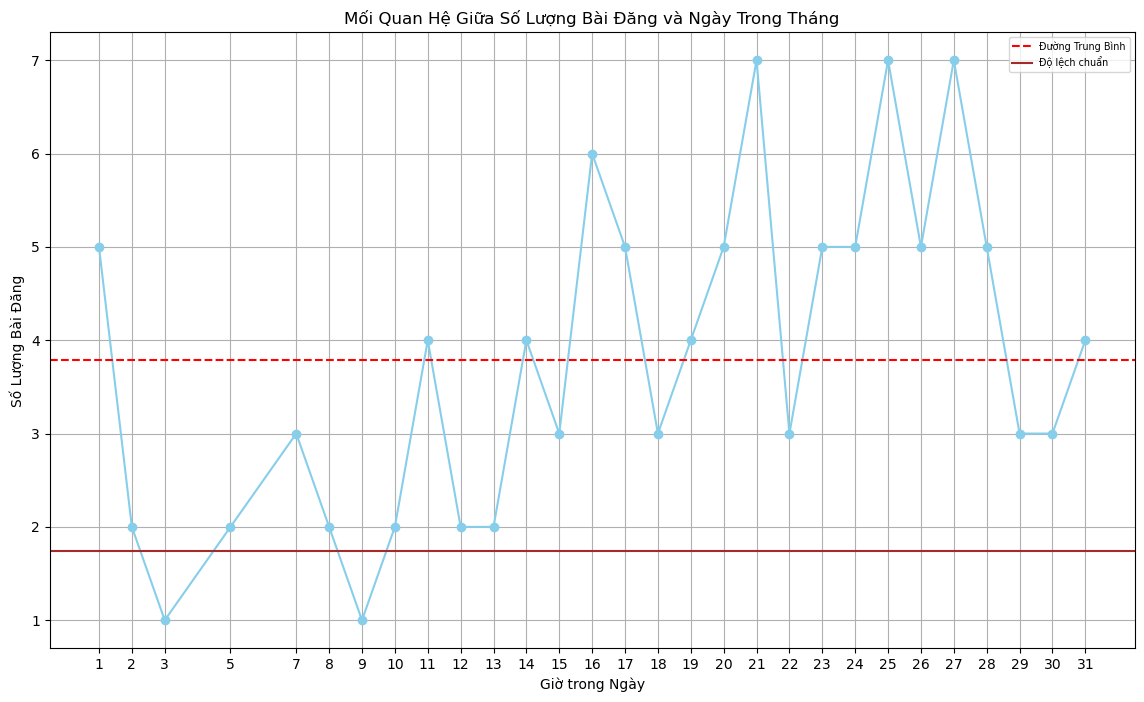

In [131]:
read_df_test['day'] = read_df_test['time'].dt.day

hourly_post_count = read_df_test['day'].value_counts().sort_index()

mean_post_count = hourly_post_count.mean()

std_post_count = hourly_post_count.std()

plt.figure(figsize=(14, 8))
plt.plot(hourly_post_count.index, hourly_post_count.values, marker='o', linestyle='-', color='skyblue')
plt.axhline(mean_post_count, color='red', linestyle='--', label='Đường Trung Bình')
plt.axhline(std_post_count, color='brown', linestyle='-', label='Độ lệch chuẩn')

plt.xlabel('Giờ trong Ngày')
plt.ylabel('Số Lượng Bài Đăng')
plt.title('Mối Quan Hệ Giữa Số Lượng Bài Đăng và Ngày Trong Tháng')
plt.xticks(hourly_post_count.index)
plt.grid(True)
plt.legend(fontsize='x-small')

plt.show()

#### The varying interaction levels between posts

In [136]:
read_df_test = read_df.copy()
read_df_test['total_reactions'] = read_df_test['reactions'].apply(lambda x: sum(x.values()))

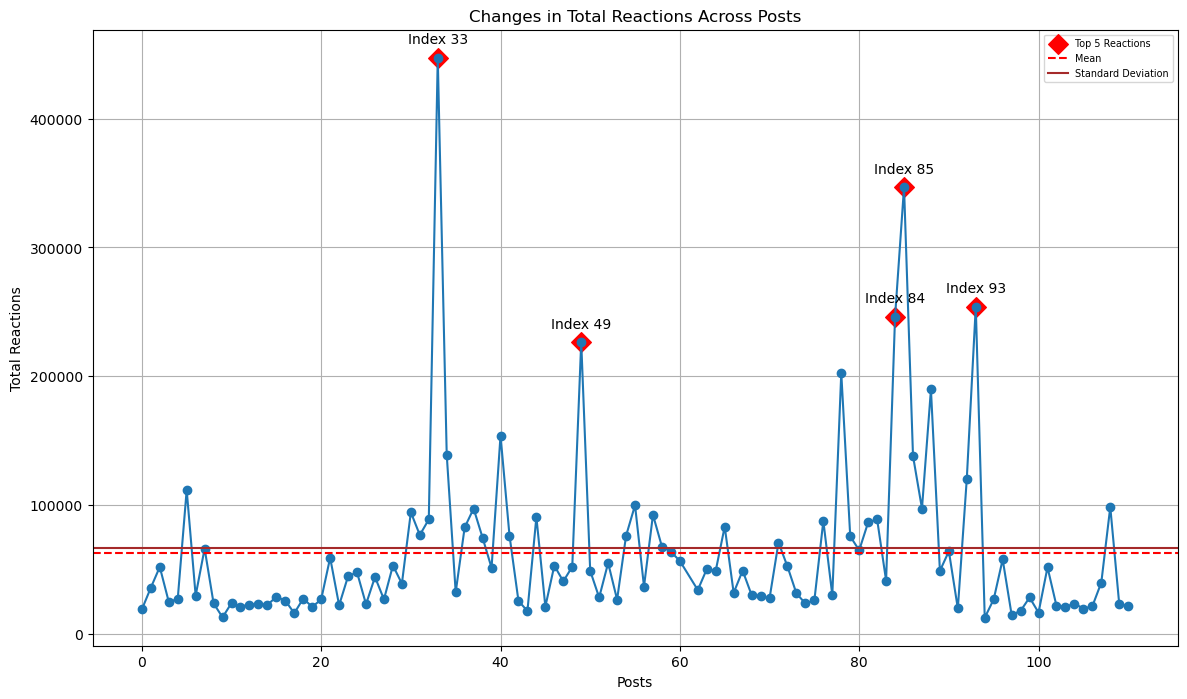

In [138]:
# Assuming 'total_reactions' is a column in your DataFrame
mean_value = read_df_test['total_reactions'].mean()
std_value = read_df_test['total_reactions'].std()

# Get the top 5 values and their indices
top_5_values = read_df_test['total_reactions'].nlargest(5)
top_5_indices = top_5_values.index

plt.figure(figsize=(14, 8))

# Plot the total reactions
plt.plot(read_df_test.index, read_df_test['total_reactions'], marker='o', linestyle='-')

# Highlight the top 5 values with a different marker or color
plt.scatter(top_5_indices, top_5_values.values, color='red', marker='D', s=100, label='Top 5 Reactions')

# Annotate the top 5 values with their indices
for i, txt in enumerate(top_5_values):
    plt.annotate(f'Index {top_5_indices[i]}', (top_5_indices[i], txt), textcoords="offset points", xytext=(0,10), ha='center')

# Add mean and standard deviation lines
plt.axhline(y=mean_value, color='r', linestyle='--', label='Mean')
plt.axhline(y=std_value, color='brown', linestyle='-', label='Standard Deviation')

plt.title('Changes in Total Reactions Across Posts')
plt.xlabel('Posts')
plt.ylabel('Total Reactions')
plt.grid(True)
plt.legend(fontsize='x-small')

plt.show()

#### The relationship between reactions and other conditions

In [88]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, 0 to 110
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   post_id        110 non-null    int64         
 1   post_text      110 non-null    object        
 2   shared_text    5 non-null      object        
 3   time           110 non-null    datetime64[ns]
 4   shared_time    2 non-null      object        
 5   comments_full  110 non-null    object        
 6   reactors       35 non-null     object        
 7   reactions      110 non-null    object        
 8   image_ids      84 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 12.7+ KB


##### The impact of posting time on post interactions

In [89]:
read_df_test = read_df.copy()

read_df_test['total_reactions'] = read_df_test['reactions'].apply(lambda x: sum(x.values()))
read_df_test['day_of_week'] = read_df_test['time'].dt.day_name()
read_df_test['hour'] = read_df_test['time'].dt.hour

In [90]:
Monday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Monday']
Monday_Hourly_Reaction_Sum = Monday_Intereactions.groupby('hour')['total_reactions'].sum()
Monday_Hourly_Reaction_Sum = pd.DataFrame(Monday_Hourly_Reaction_Sum)

Tuesday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Tuesday']
Tuesday_Hourly_Reaction_Sum = Tuesday_Intereactions.groupby('hour')['total_reactions'].sum()
Tuesday_Hourly_Reaction_Sum = pd.DataFrame(Tuesday_Hourly_Reaction_Sum)

Wednesday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Wednesday']
Wednesday_Hourly_Reaction_Sum = Wednesday_Intereactions.groupby('hour')['total_reactions'].sum()
Wednesday_Hourly_Reaction_Sum = pd.DataFrame(Wednesday_Hourly_Reaction_Sum)

Thursday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Thursday']
Thursday_Hourly_Reaction_Sum = Thursday_Intereactions.groupby('hour')['total_reactions'].sum()
Thursday_Hourly_Reaction_Sum = pd.DataFrame(Thursday_Hourly_Reaction_Sum)

Friday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Friday']
Friday_Hourly_Reaction_Sum = Friday_Intereactions.groupby('hour')['total_reactions'].sum()
Friday_Hourly_Reaction_Sum = pd.DataFrame(Friday_Hourly_Reaction_Sum)

Saturday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Saturday']
Saturday_Hourly_Reaction_Sum = Saturday_Intereactions.groupby('hour')['total_reactions'].sum()
Saturday_Hourly_Reaction_Sum = pd.DataFrame(Saturday_Hourly_Reaction_Sum)

Sunday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Sunday']
Sunday_Hourly_Reaction_Sum = Sunday_Intereactions.groupby('hour')['total_reactions'].sum()
Sunday_Hourly_Reaction_Sum = pd.DataFrame(Sunday_Hourly_Reaction_Sum)

In [91]:
hours_in_day = pd.DataFrame({'hour': range(24)})

hours_in_day['Monday'] = hours_in_day['hour'].apply(lambda x: Monday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Monday_Hourly_Reaction_Sum.index else 0)
hours_in_day['Tuesday'] = hours_in_day['hour'].apply(lambda x: Tuesday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Tuesday_Hourly_Reaction_Sum.index else 0)
hours_in_day['Wednesday'] = hours_in_day['hour'].apply(lambda x: Wednesday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Wednesday_Hourly_Reaction_Sum.index else 0)
hours_in_day['Thursday'] = hours_in_day['hour'].apply(lambda x: Thursday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Thursday_Hourly_Reaction_Sum.index else 0)
hours_in_day['Friday'] = hours_in_day['hour'].apply(lambda x: Friday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Friday_Hourly_Reaction_Sum.index else 0)
hours_in_day['Staturday'] = hours_in_day['hour'].apply(lambda x: Saturday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Saturday_Hourly_Reaction_Sum.index else 0)
hours_in_day['Sunday'] = hours_in_day['hour'].apply(lambda x: Sunday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Sunday_Hourly_Reaction_Sum.index else 0)

hours_in_day = hours_in_day.drop(columns='hour')

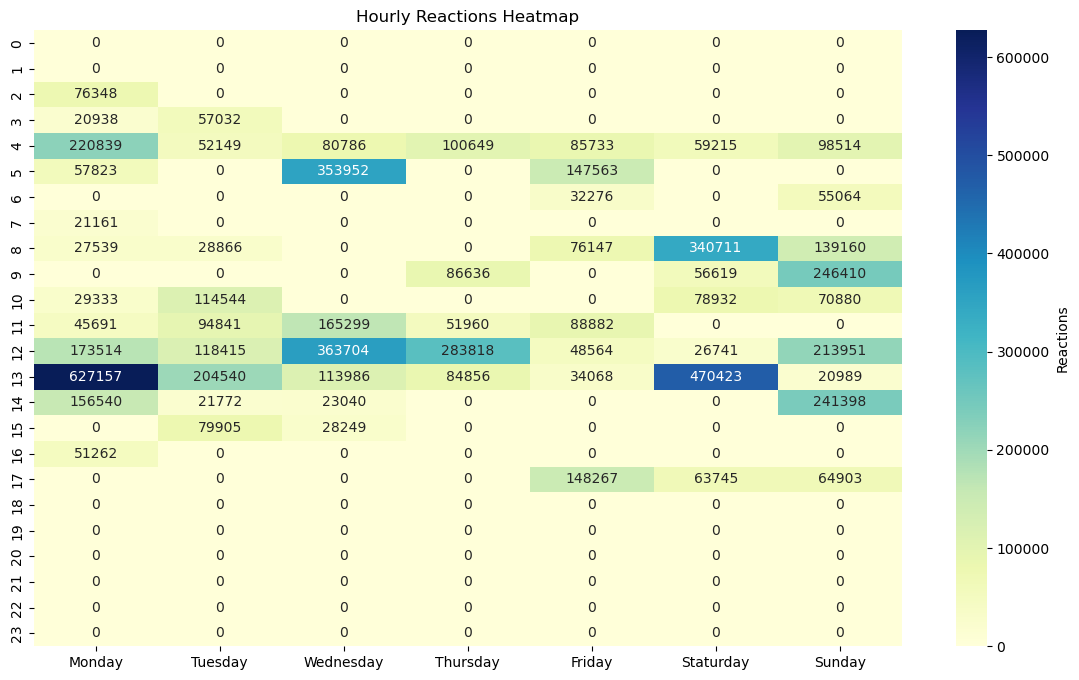

In [92]:
plt.figure(figsize=(14, 8))
sns.heatmap(hours_in_day, cmap='YlGnBu', annot=True, fmt='g', cbar_kws={'label': 'Reactions'})
plt.title('Hourly Reactions Heatmap')

plt.show()

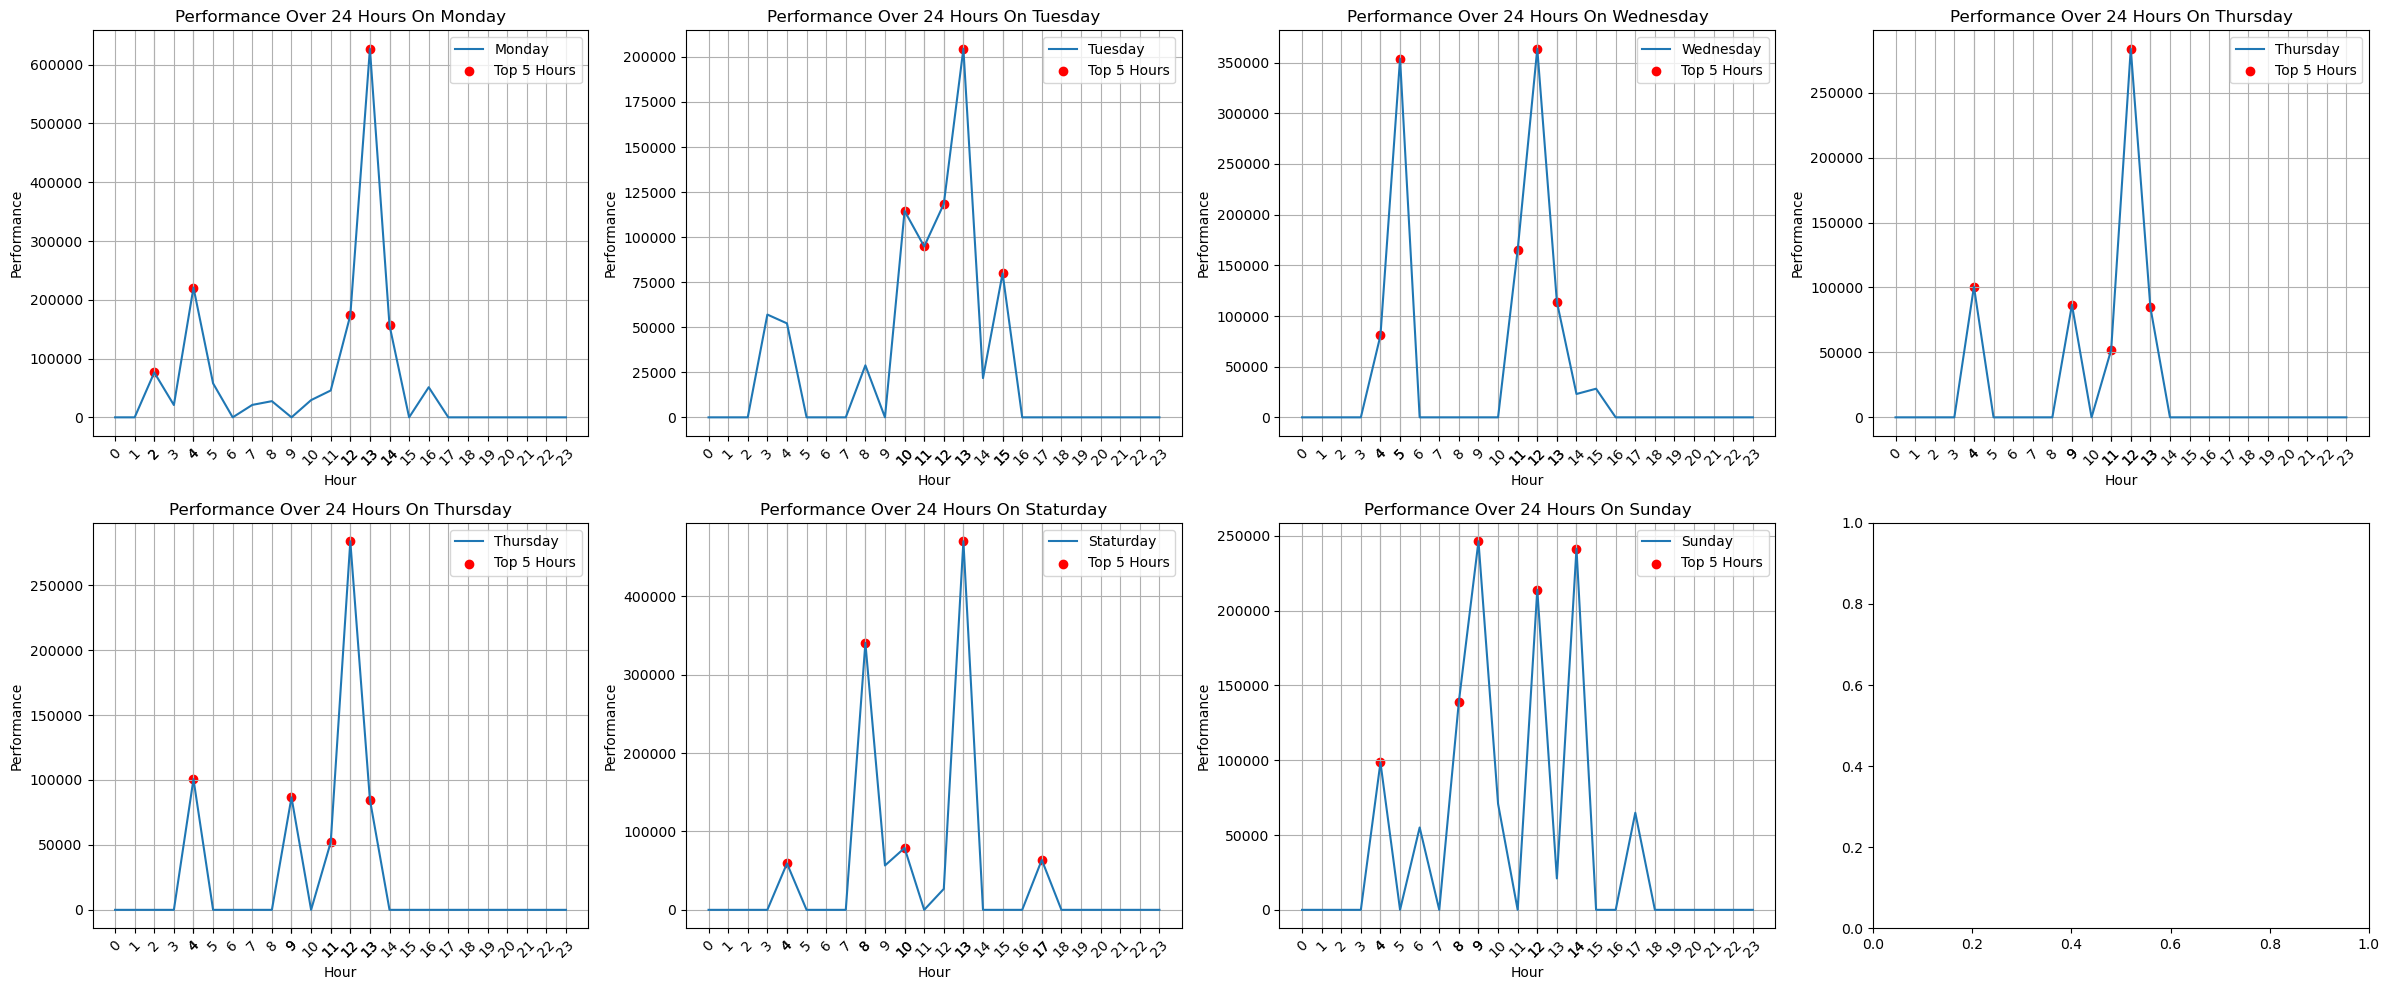

In [93]:
top5_hours = hours_in_day.nlargest(5, 'Monday')

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 10))

axes[0, 0].plot(hours_in_day.index, hours_in_day['Monday'], label='Monday')
axes[0, 0].scatter(top5_hours.index, top5_hours['Monday'], color='red', label='Top 5 Hours')

axes[0, 0].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[0, 0].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[0, 0].set_title('Performance Over 24 Hours On Monday')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Performance')
axes[0, 0].legend()
axes[0, 0].grid(True)

top5_hours = hours_in_day.nlargest(5, 'Tuesday')

axes[0, 1].plot(hours_in_day.index, hours_in_day['Tuesday'], label='Tuesday')
axes[0, 1].scatter(top5_hours.index, top5_hours['Tuesday'], color='red', label='Top 5 Hours')

axes[0, 1].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[0, 1].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[0, 1].set_title('Performance Over 24 Hours On Tuesday')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Performance')
axes[0, 1].legend()
axes[0, 1].grid(True)

top5_hours = hours_in_day.nlargest(5, 'Wednesday')

axes[0, 2].plot(hours_in_day.index, hours_in_day['Wednesday'], label='Wednesday')
axes[0, 2].scatter(top5_hours.index, top5_hours['Wednesday'], color='red', label='Top 5 Hours')

axes[0, 2].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[0, 2].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[0, 2].set_title('Performance Over 24 Hours On Wednesday')
axes[0, 2].set_xlabel('Hour')
axes[0, 2].set_ylabel('Performance')
axes[0, 2].legend()
axes[0, 2].grid(True)

top5_hours = hours_in_day.nlargest(5, 'Thursday')

axes[0, 3].plot(hours_in_day.index, hours_in_day['Thursday'], label='Thursday')
axes[0, 3].scatter(top5_hours.index, top5_hours['Thursday'], color='red', label='Top 5 Hours')

axes[0, 3].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[0, 3].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[0, 3].set_title('Performance Over 24 Hours On Thursday')
axes[0, 3].set_xlabel('Hour')
axes[0, 3].set_ylabel('Performance')
axes[0, 3].legend()
axes[0, 3].grid(True)

top5_hours = hours_in_day.nlargest(5, 'Thursday')

axes[1, 0].plot(hours_in_day.index, hours_in_day['Thursday'], label='Thursday')
axes[1, 0].scatter(top5_hours.index, top5_hours['Thursday'], color='red', label='Top 5 Hours')

axes[1, 0].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[1, 0].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[1, 0].set_title('Performance Over 24 Hours On Thursday')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Performance')
axes[1, 0].legend()
axes[1, 0].grid(True)

top5_hours = hours_in_day.nlargest(5, 'Staturday')

axes[1, 1].plot(hours_in_day.index, hours_in_day['Staturday'], label='Staturday')
axes[1, 1].scatter(top5_hours.index, top5_hours['Staturday'], color='red', label='Top 5 Hours')

axes[1, 1].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[1, 1].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[1, 1].set_title('Performance Over 24 Hours On Staturday')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Performance')
axes[1, 1].legend()
axes[1, 1].grid(True)

top5_hours = hours_in_day.nlargest(5, 'Sunday')

axes[1, 2].plot(hours_in_day.index, hours_in_day['Sunday'], label='Sunday')
axes[1, 2].scatter(top5_hours.index, top5_hours['Sunday'], color='red', label='Top 5 Hours')

axes[1, 2].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[1, 2].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[1, 2].set_title('Performance Over 24 Hours On Sunday')
axes[1, 2].set_xlabel('Hour')
axes[1, 2].set_ylabel('Performance')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()

plt.show()

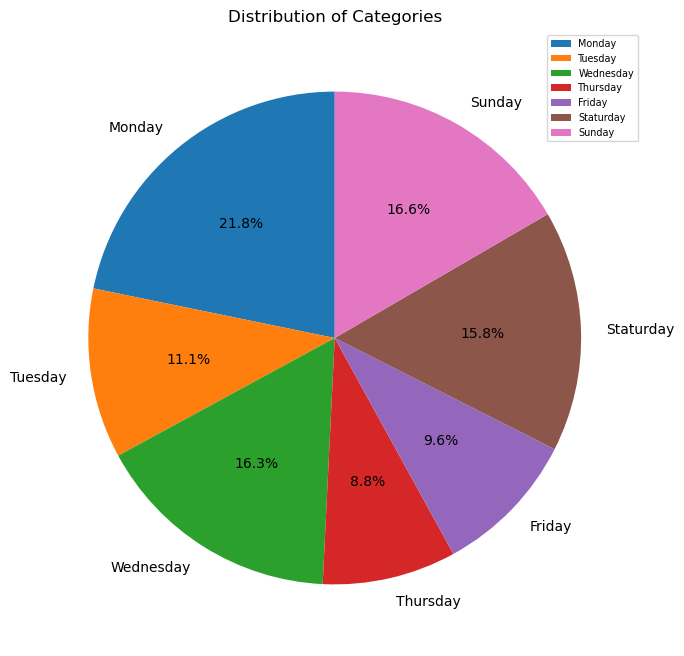

In [94]:
hours_in_day.head(200)

columns_sum = hours_in_day.sum()
columns_sum = columns_sum.to_dict()

plt.figure(figsize=(14, 8))
plt.pie(columns_sum.values(), labels=columns_sum.keys(), autopct='%1.1f%%', startangle=90)

plt.title('Distribution of Categories')
plt.legend(fontsize='x-small')

plt.show()

In [95]:
Monday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Monday']
Monday_Hourly_Reaction_Sum = Monday_Intereactions.groupby('hour')['total_reactions'].mean()
Monday_Hourly_Reaction_Sum = pd.DataFrame(Monday_Hourly_Reaction_Sum)

Tuesday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Tuesday']
Tuesday_Hourly_Reaction_Sum = Tuesday_Intereactions.groupby('hour')['total_reactions'].mean()
Tuesday_Hourly_Reaction_Sum = pd.DataFrame(Tuesday_Hourly_Reaction_Sum)

Wednesday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Wednesday']
Wednesday_Hourly_Reaction_Sum = Wednesday_Intereactions.groupby('hour')['total_reactions'].mean()
Wednesday_Hourly_Reaction_Sum = pd.DataFrame(Wednesday_Hourly_Reaction_Sum)

Thursday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Thursday']
Thursday_Hourly_Reaction_Sum = Thursday_Intereactions.groupby('hour')['total_reactions'].mean()
Thursday_Hourly_Reaction_Sum = pd.DataFrame(Thursday_Hourly_Reaction_Sum)

Friday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Friday']
Friday_Hourly_Reaction_Sum = Friday_Intereactions.groupby('hour')['total_reactions'].mean()
Friday_Hourly_Reaction_Sum = pd.DataFrame(Friday_Hourly_Reaction_Sum)

Saturday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Saturday']
Saturday_Hourly_Reaction_Sum = Saturday_Intereactions.groupby('hour')['total_reactions'].mean()
Saturday_Hourly_Reaction_Sum = pd.DataFrame(Saturday_Hourly_Reaction_Sum)

Sunday_Intereactions = read_df_test[read_df_test['day_of_week'] == 'Sunday']
Sunday_Hourly_Reaction_Sum = Sunday_Intereactions.groupby('hour')['total_reactions'].mean()
Sunday_Hourly_Reaction_Sum = pd.DataFrame(Sunday_Hourly_Reaction_Sum)

In [96]:
hours_in_day = pd.DataFrame({'hour': range(24)})

hours_in_day['Monday'] = hours_in_day['hour'].apply(lambda x: Monday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Monday_Hourly_Reaction_Sum.index else 0)
hours_in_day['Tuesday'] = hours_in_day['hour'].apply(lambda x: Tuesday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Tuesday_Hourly_Reaction_Sum.index else 0)
hours_in_day['Wednesday'] = hours_in_day['hour'].apply(lambda x: Wednesday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Wednesday_Hourly_Reaction_Sum.index else 0)
hours_in_day['Thursday'] = hours_in_day['hour'].apply(lambda x: Thursday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Thursday_Hourly_Reaction_Sum.index else 0)
hours_in_day['Friday'] = hours_in_day['hour'].apply(lambda x: Friday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Friday_Hourly_Reaction_Sum.index else 0)
hours_in_day['Staturday'] = hours_in_day['hour'].apply(lambda x: Saturday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Saturday_Hourly_Reaction_Sum.index else 0)
hours_in_day['Sunday'] = hours_in_day['hour'].apply(lambda x: Sunday_Hourly_Reaction_Sum.loc[x, 'total_reactions'] if x in Sunday_Hourly_Reaction_Sum.index else 0)

hours_in_day = hours_in_day.drop(columns='hour')

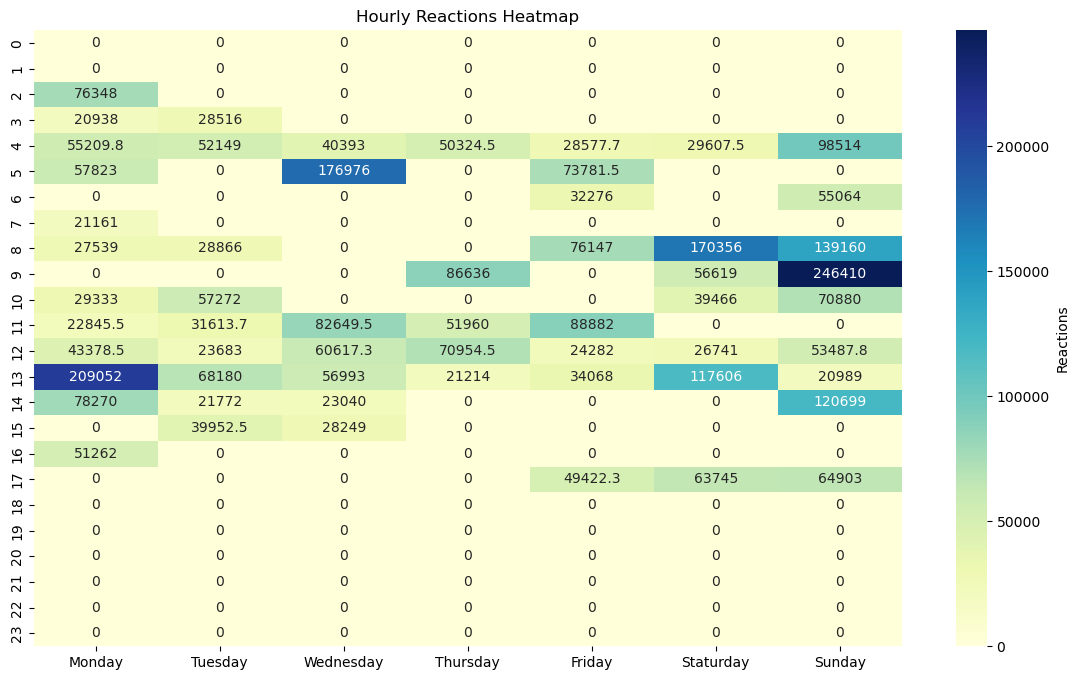

In [97]:
plt.figure(figsize=(14, 8))
sns.heatmap(hours_in_day, cmap='YlGnBu', annot=True, fmt='g', cbar_kws={'label': 'Reactions'})
plt.title('Hourly Reactions Heatmap')

plt.show()

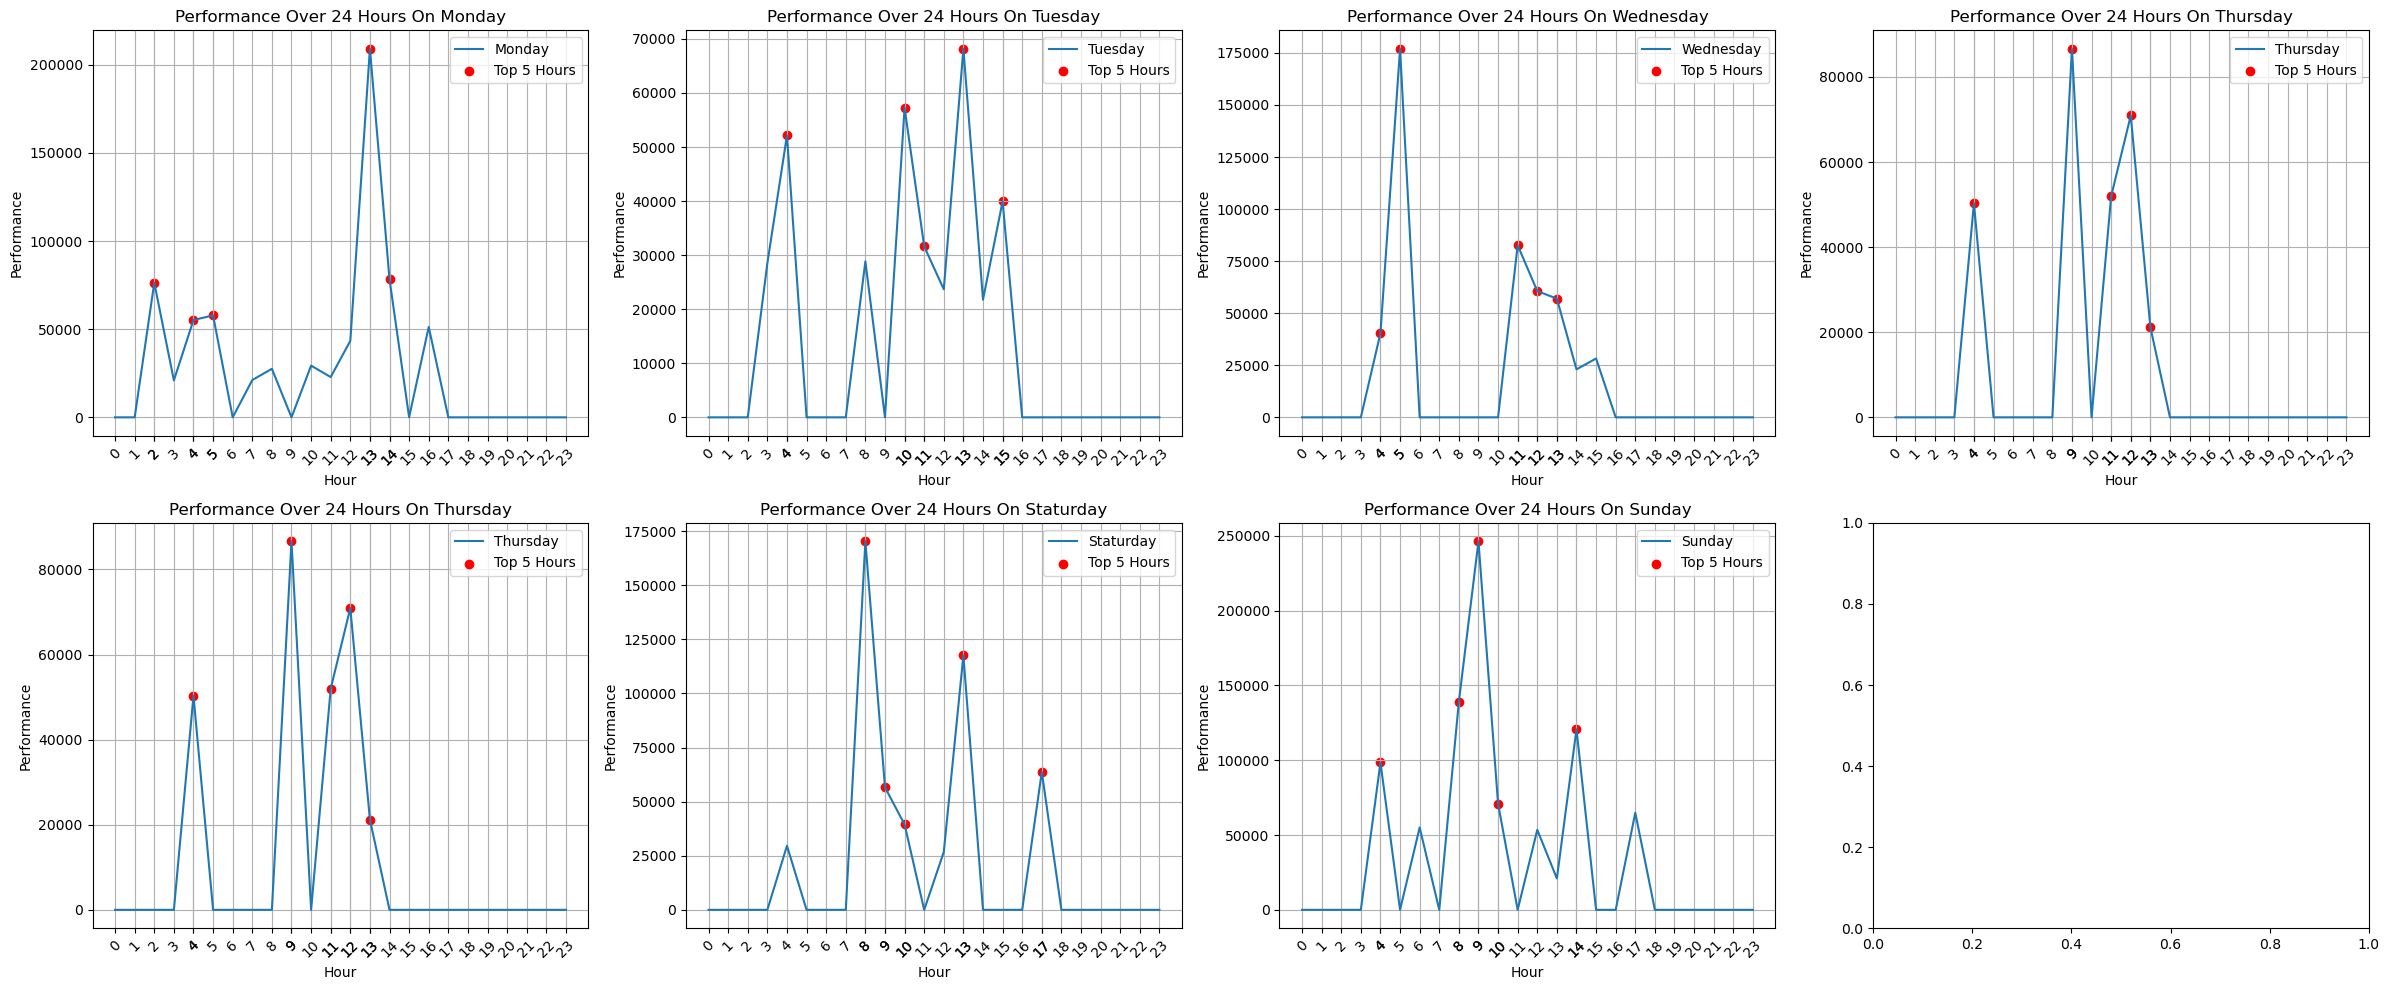

In [98]:
top5_hours = hours_in_day.nlargest(5, 'Monday')

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 10))

axes[0, 0].plot(hours_in_day.index, hours_in_day['Monday'], label='Monday')
axes[0, 0].scatter(top5_hours.index, top5_hours['Monday'], color='red', label='Top 5 Hours')

axes[0, 0].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[0, 0].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[0, 0].set_title('Performance Over 24 Hours On Monday')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Performance')
axes[0, 0].legend()
axes[0, 0].grid(True)

top5_hours = hours_in_day.nlargest(5, 'Tuesday')

axes[0, 1].plot(hours_in_day.index, hours_in_day['Tuesday'], label='Tuesday')
axes[0, 1].scatter(top5_hours.index, top5_hours['Tuesday'], color='red', label='Top 5 Hours')

axes[0, 1].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[0, 1].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[0, 1].set_title('Performance Over 24 Hours On Tuesday')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Performance')
axes[0, 1].legend()
axes[0, 1].grid(True)

top5_hours = hours_in_day.nlargest(5, 'Wednesday')

axes[0, 2].plot(hours_in_day.index, hours_in_day['Wednesday'], label='Wednesday')
axes[0, 2].scatter(top5_hours.index, top5_hours['Wednesday'], color='red', label='Top 5 Hours')

axes[0, 2].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[0, 2].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[0, 2].set_title('Performance Over 24 Hours On Wednesday')
axes[0, 2].set_xlabel('Hour')
axes[0, 2].set_ylabel('Performance')
axes[0, 2].legend()
axes[0, 2].grid(True)

top5_hours = hours_in_day.nlargest(5, 'Thursday')

axes[0, 3].plot(hours_in_day.index, hours_in_day['Thursday'], label='Thursday')
axes[0, 3].scatter(top5_hours.index, top5_hours['Thursday'], color='red', label='Top 5 Hours')

axes[0, 3].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[0, 3].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[0, 3].set_title('Performance Over 24 Hours On Thursday')
axes[0, 3].set_xlabel('Hour')
axes[0, 3].set_ylabel('Performance')
axes[0, 3].legend()
axes[0, 3].grid(True)

top5_hours = hours_in_day.nlargest(5, 'Thursday')

axes[1, 0].plot(hours_in_day.index, hours_in_day['Thursday'], label='Thursday')
axes[1, 0].scatter(top5_hours.index, top5_hours['Thursday'], color='red', label='Top 5 Hours')

axes[1, 0].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[1, 0].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[1, 0].set_title('Performance Over 24 Hours On Thursday')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Performance')
axes[1, 0].legend()
axes[1, 0].grid(True)

top5_hours = hours_in_day.nlargest(5, 'Staturday')

axes[1, 1].plot(hours_in_day.index, hours_in_day['Staturday'], label='Staturday')
axes[1, 1].scatter(top5_hours.index, top5_hours['Staturday'], color='red', label='Top 5 Hours')

axes[1, 1].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[1, 1].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[1, 1].set_title('Performance Over 24 Hours On Staturday')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Performance')
axes[1, 1].legend()
axes[1, 1].grid(True)

top5_hours = hours_in_day.nlargest(5, 'Sunday')

axes[1, 2].plot(hours_in_day.index, hours_in_day['Sunday'], label='Sunday')
axes[1, 2].scatter(top5_hours.index, top5_hours['Sunday'], color='red', label='Top 5 Hours')

axes[1, 2].set_xticks(hours_in_day.index.tolist() + top5_hours.index.tolist())
axes[1, 2].set_xticklabels(hours_in_day.index.tolist() + top5_hours.index.astype(str).tolist(), rotation=45)
    
axes[1, 2].set_title('Performance Over 24 Hours On Sunday')
axes[1, 2].set_xlabel('Hour')
axes[1, 2].set_ylabel('Performance')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()

plt.show()

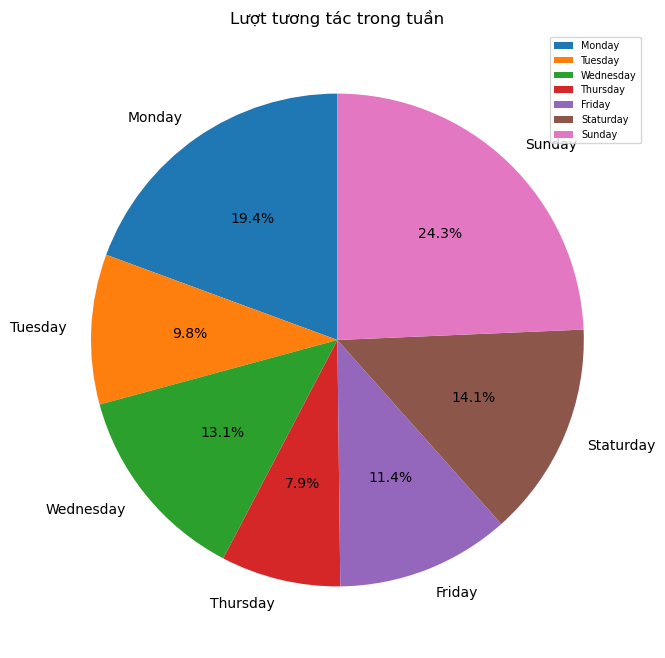

In [99]:
hours_in_day.head(200)

columns_sum = hours_in_day.sum()
columns_sum = columns_sum.to_dict()

plt.figure(figsize=(14, 8))
plt.pie(columns_sum.values(), labels=columns_sum.keys(), autopct='%1.1f%%', startangle=90)

plt.title('Lượt tương tác trong tuần')
plt.legend(fontsize='x-small')

plt.show()

##### The impact of posting frequency on intereactions

In [100]:
read_df_test = read_df.copy()
read_df_test['total_reactions'] = read_df_test['reactions'].apply(lambda x: sum(x.values()))

read_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, 0 to 110
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   post_id          110 non-null    int64         
 1   post_text        110 non-null    object        
 2   shared_text      5 non-null      object        
 3   time             110 non-null    datetime64[ns]
 4   shared_time      2 non-null      object        
 5   comments_full    110 non-null    object        
 6   reactors         35 non-null     object        
 7   reactions        110 non-null    object        
 8   image_ids        84 non-null     object        
 9   total_reactions  110 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 13.5+ KB


In [141]:
read_df_test['day'] = read_df_test['time'].dt.strftime('%Y-%m-%d')
read_df_test['day'] = pd.to_datetime(read_df_test['day'])
read_df_test['week'] = read_df_test['day'].dt.isocalendar().week

In [142]:
arvage_reactions_of_week = read_df_test.groupby('week')['total_reactions'].mean()
total_post_of_week = read_df_test.groupby('week')['total_reactions'].count()
arvage_reactions_of_week = arvage_reactions_of_week.to_dict()
total_post_of_week = total_post_of_week.to_dict()

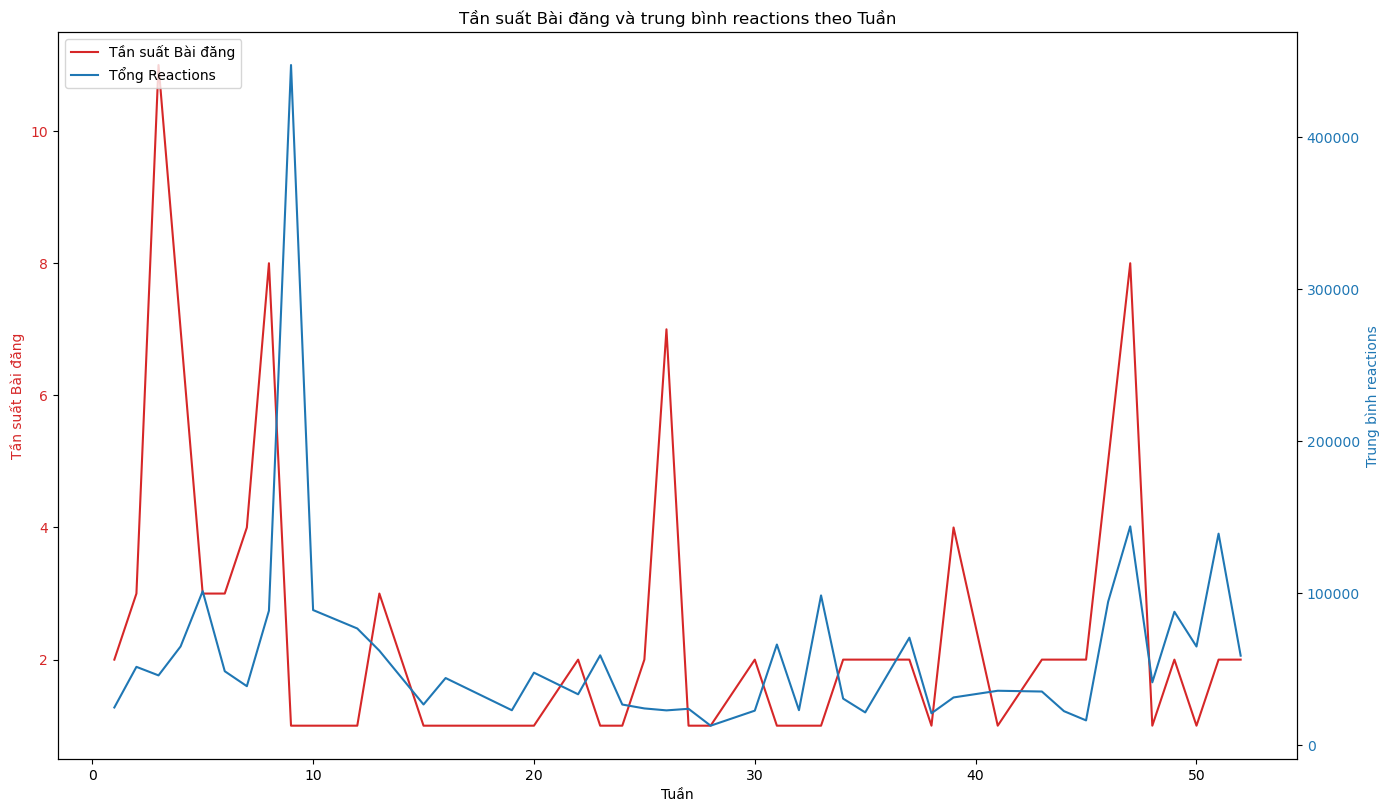

In [146]:
weeks = list(arvage_reactions_of_week.keys())
arvage_reactions = list(arvage_reactions_of_week.values())
post = list(total_post_of_week.values())  # Corrected variable assignment

fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:red'
ax1.set_xlabel('Tuần')
ax1.set_ylabel('Tần suất Bài đăng', color=color)
line1 = ax1.plot(weeks, post, color=color, label='Tần suất Bài đăng')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Trung bình reactions', color=color)
line2 = ax2.plot(weeks, arvage_reactions, color=color, label='Tổng Reactions')
ax2.tick_params(axis='y', labelcolor=color)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

fig.tight_layout()
plt.title('Tần suất Bài đăng và trung bình reactions theo Tuần')
plt.show()

In [147]:
post = pd.Series(post)
total_reactions = pd.Series(total_reactions)

correlation = post.corr(total_reactions)
print(correlation)

-0.11916332948725357


In [152]:
arvage_reactions_of_day = read_df_test.groupby('day')['total_reactions'].mean()
total_post_of_day = read_df_test.groupby('day')['total_reactions'].count()
arvage_reactions_of_day = arvage_reactions_of_day.to_dict()
total_post_of_day = total_post_of_day.to_dict()

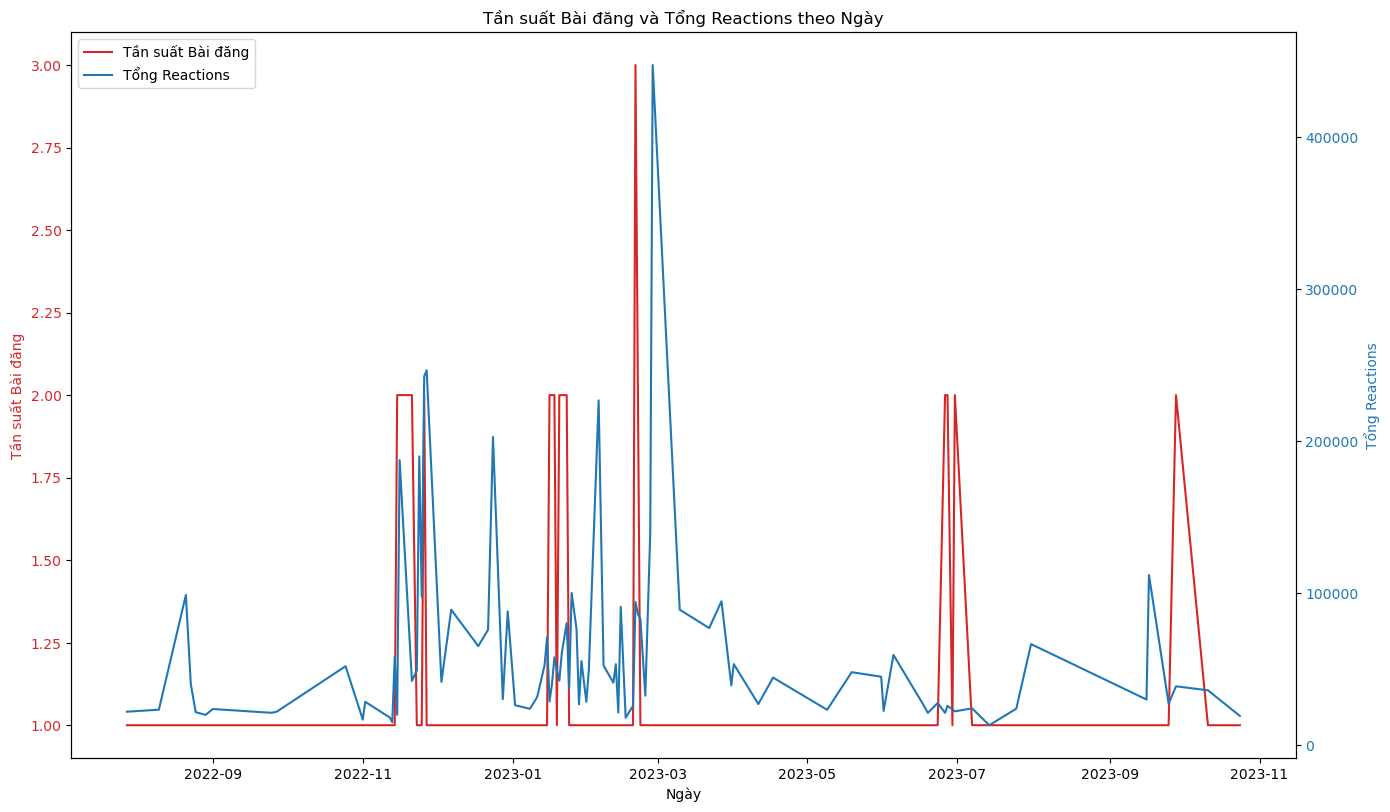

In [153]:
days = list(arvage_reactions_of_day.keys())
total_reactions = list(arvage_reactions_of_day.values())  # Corrected variable name
post = list(total_post_of_day.values())

fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:red'
ax1.set_xlabel('Ngày')
ax1.set_ylabel('Tần suất Bài đăng', color=color)
line1 = ax1.plot(days, post, color=color, label='Tần suất Bài đăng')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Tổng Reactions', color=color)
line2 = ax2.plot(days, total_reactions, color=color, label='Tổng Reactions')
ax2.tick_params(axis='y', labelcolor=color)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

fig.tight_layout()
plt.title('Tần suất Bài đăng và Tổng Reactions theo Ngày')
plt.show()

In [154]:
post = pd.Series(post)
total_reactions = pd.Series(total_reactions)

correlation = post.corr(total_reactions)
print(correlation)

0.052837803824040144


##### The influence of images in posts on interaction

In [108]:
read_df_test = read_df.copy()
read_df_test['total_reactions'] = read_df_test['reactions'].apply(lambda x: sum(x.values()))

read_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, 0 to 110
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   post_id          110 non-null    int64         
 1   post_text        110 non-null    object        
 2   shared_text      5 non-null      object        
 3   time             110 non-null    datetime64[ns]
 4   shared_time      2 non-null      object        
 5   comments_full    110 non-null    object        
 6   reactors         35 non-null     object        
 7   reactions        110 non-null    object        
 8   image_ids        84 non-null     object        
 9   total_reactions  110 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 13.5+ KB


In [109]:
total_reactions_with_image = read_df_test.loc[read_df_test['image_ids'].notna()]['total_reactions'].sum()
average_reactions_with_image = read_df_test.loc[read_df_test['image_ids'].notna()]['total_reactions'].mean()

total_reactions_without_image = read_df_test.loc[read_df_test['image_ids'].isna()]['total_reactions'].sum()
average_reactions_without_image = read_df_test.loc[read_df_test['image_ids'].isna()]['total_reactions'].mean()

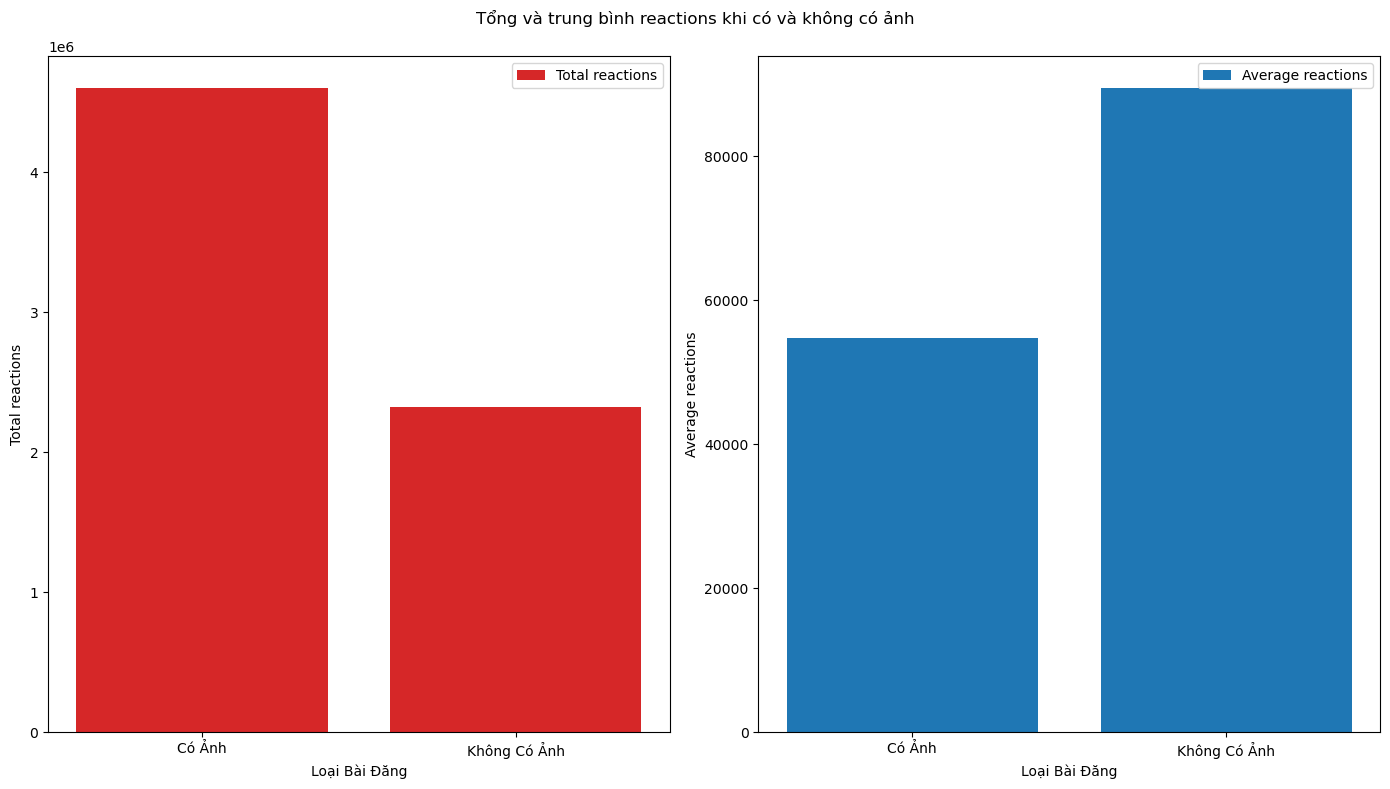

In [110]:
data = {'type_post': ['Có Ảnh', 'Không Có Ảnh'],
        'total_reactions': [total_reactions_with_image, total_reactions_without_image],
        'average_reactions': [average_reactions_with_image, average_reactions_without_image]
       }

df = pd.DataFrame(data)

plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
color1 = 'tab:red'
plt.bar(df['type_post'], df['total_reactions'], color=color1, label='Total reactions')
plt.xlabel('Loại Bài Đăng')
plt.ylabel('Total reactions')
plt.legend()

plt.subplot(1, 2, 2)
color2 = 'tab:blue'
plt.bar(df['type_post'], df['average_reactions'], color=color2, label='Average reactions')
plt.xlabel('Loại Bài Đăng')
plt.ylabel('Average reactions')
plt.legend()

plt.suptitle('Tổng và trung bình reactions khi có và không có ảnh')
plt.tight_layout()

plt.show()

##### The impact of text length on interaction rates

In [156]:
read_df_test = read_df.copy()
read_df_test['total_reactions'] = read_df_test['reactions'].apply(lambda x: sum(x.values()))
read_df_test['length_post_test'] = read_df_test['post_text'].apply(lambda x : len(x))

In [157]:
read_df_test['reactions'][0]

{'thích': 9660,
 'yêu thích': 1543,
 'haha': 5682,
 'wow': 86,
 'thương thương': 148,
 'buồn': 103,
 'phẫn nộ': 24,
 'shares': 255,
 'comments': 1440}

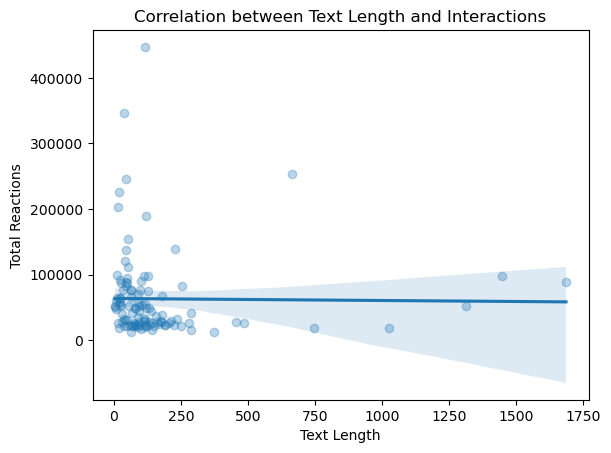

In [167]:
sns.regplot(data=read_df_test, x='length_post_test', y='total_reactions', scatter_kws={'alpha':0.3})

plt.title('Correlation between Text Length and Interactions')
plt.xlabel('Text Length')
plt.ylabel('Total Reactions')

plt.show()

##### Common words in post

In [114]:
read_df_test = read_df.copy()

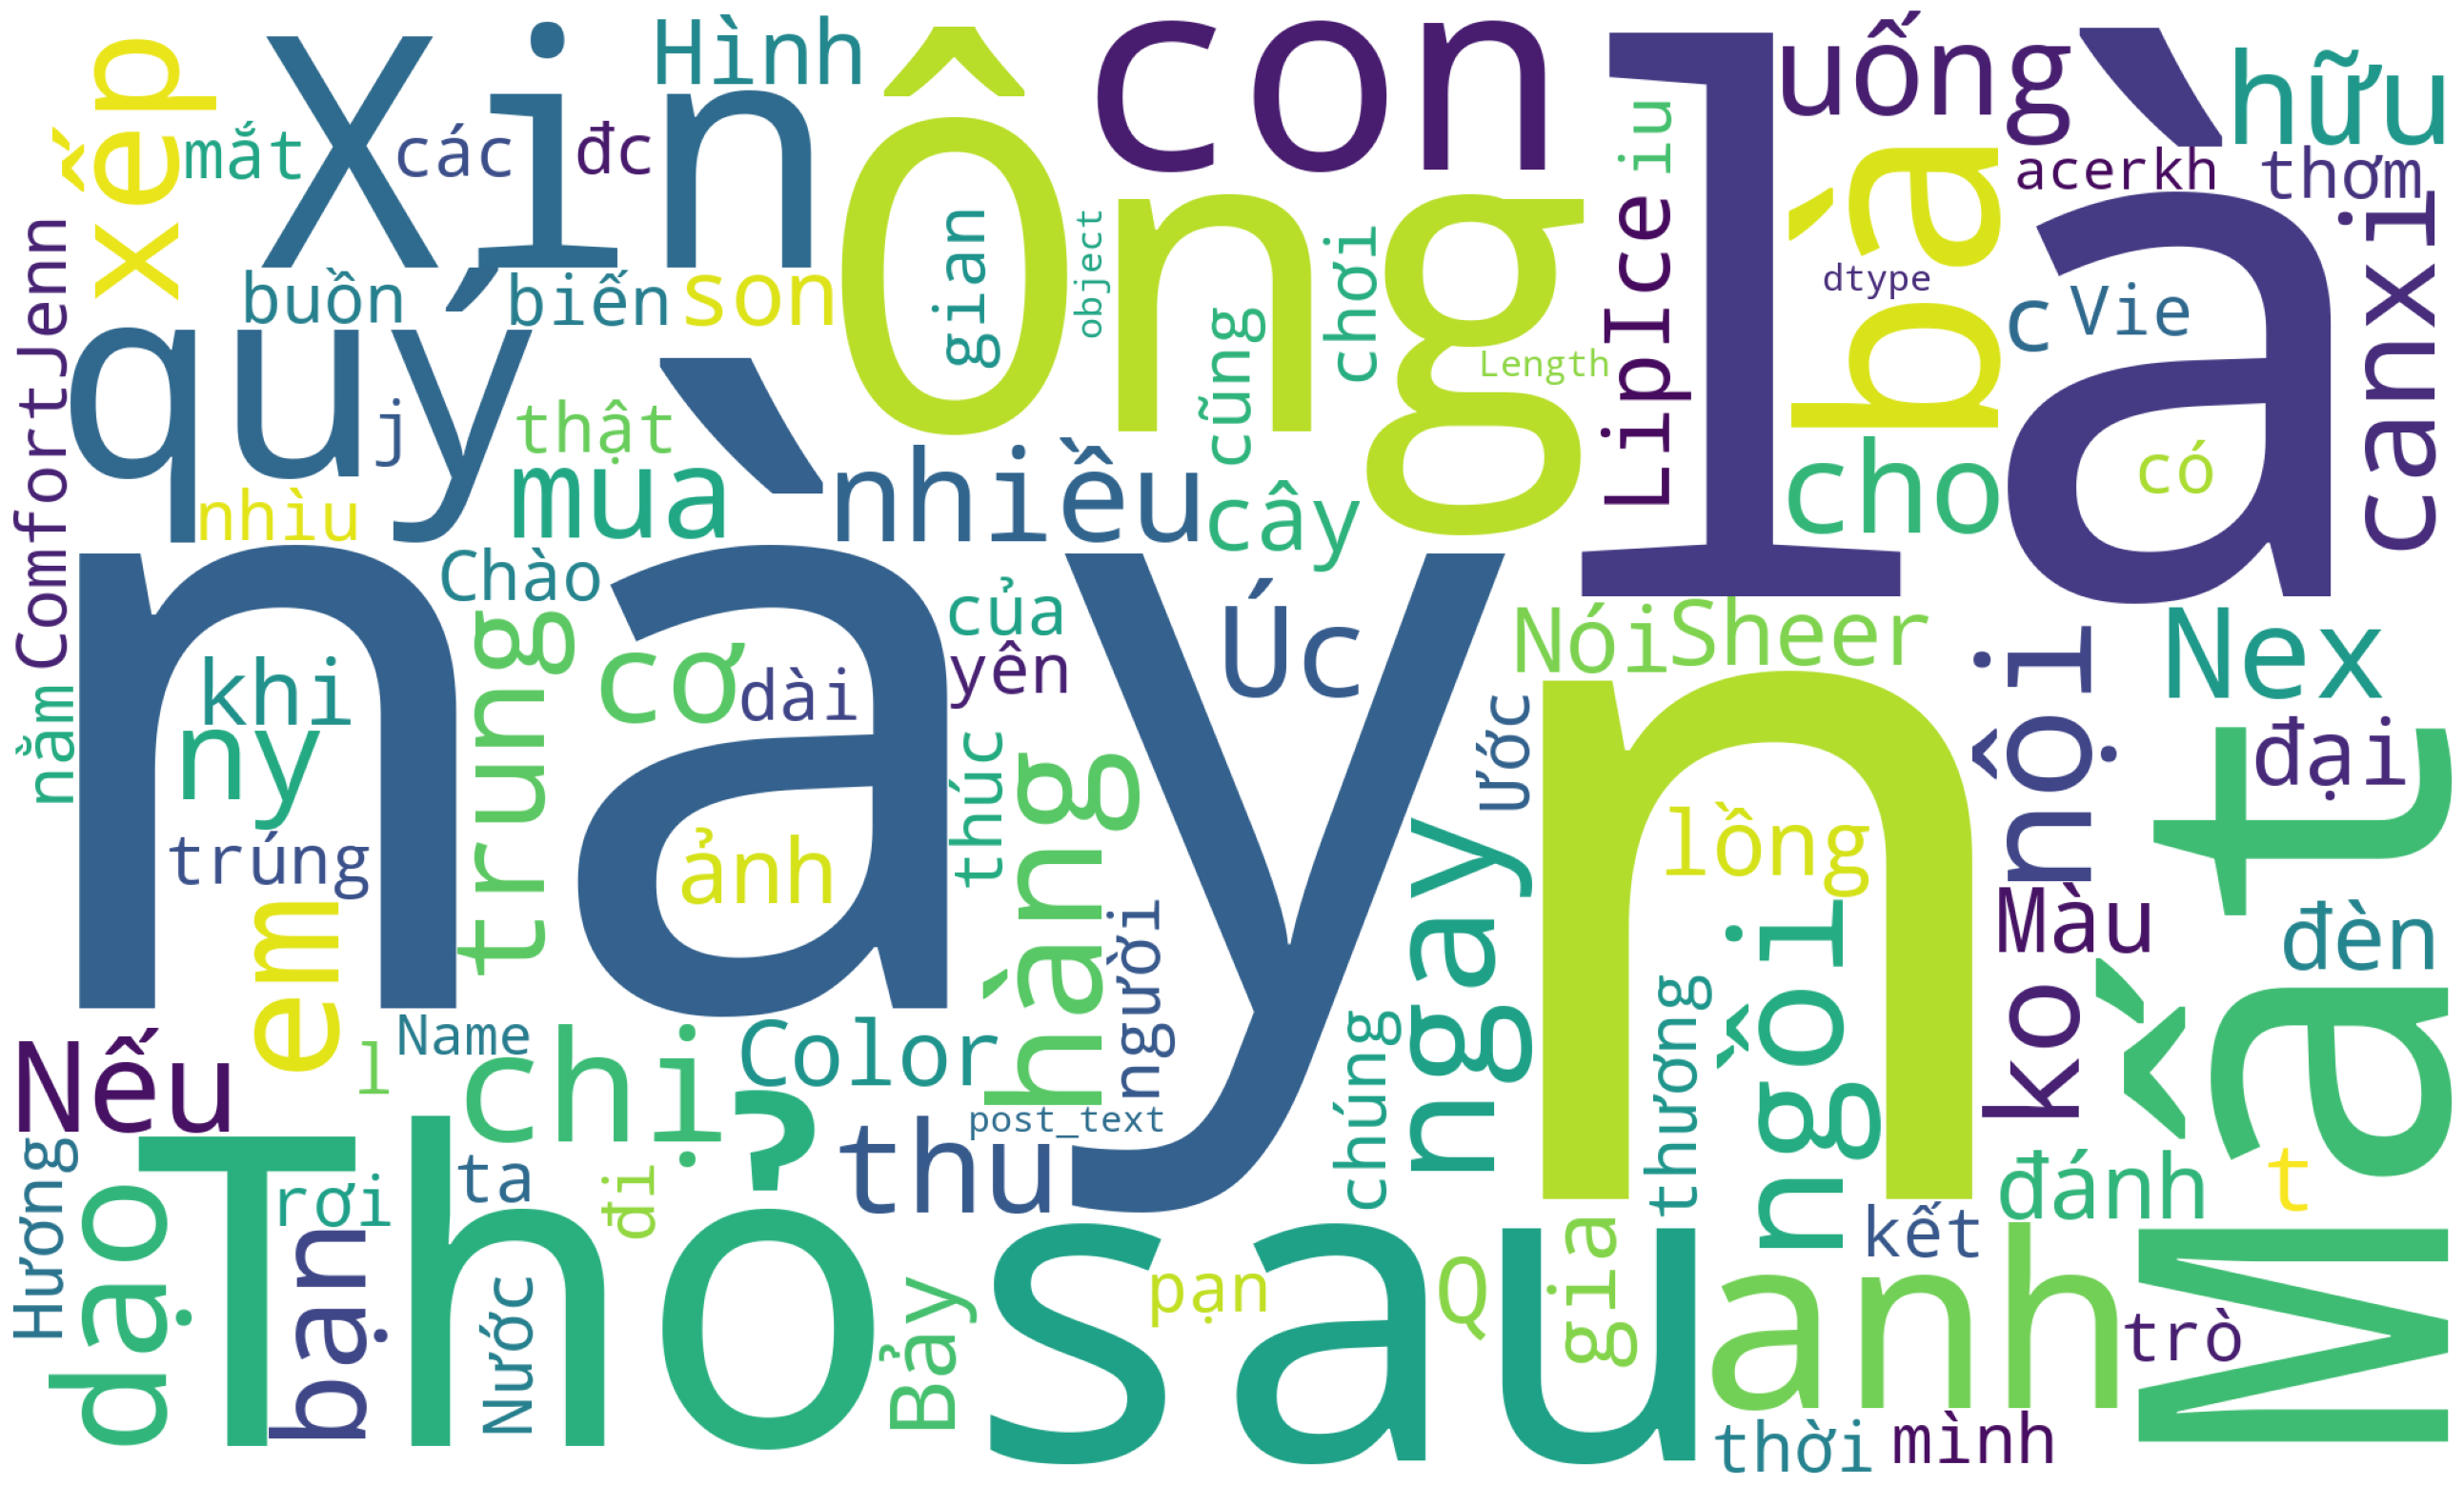

In [243]:
from wordcloud import WordCloud, STOPWORDS

full_post_text = str(read_df_test['post_text'])

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=300,
                      width=2000, height=1200
                         ).generate(full_post_text)

plt.figure(figsize=(40,20))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')

plt.savefig('my_pie_chart.png')

plt.show()

##### Sentiment analysis of comments

In [237]:
read_df['total_reactions'] = read_df_test['reactions'].apply(lambda x: sum(x.values()))

In [201]:
read_df['reactions'][0]

{'thích': 9660,
 'yêu thích': 1543,
 'haha': 5682,
 'wow': 86,
 'thương thương': 148,
 'buồn': 103,
 'phẫn nộ': 24,
 'shares': 255,
 'comments': 1440}

In [202]:
from transformers import pipeline
from googletrans import Translator, constants
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [226]:
read_df[['NEGATIVE', 'POSITIVE']] = np.nan
read_df.fillna(0, inplace=True)

In [233]:
count = 0
sentiment_results = []


for post in read_df_test['comments_full']: 
    results_df = []
    comments = []

    try:
        post_clean = re.sub(r'datetime\.datetime\([^)]*\)', 'None', post)
        for comment in eval(post_clean):
            cmt_text = re.sub(r'\W+', ' ', comment['comment_text'])
            if cmt_text not in comments:
                comments.append(cmt_text)
    except ValueError as e:
        print({e})
        continue  

    labels = sentiment_analysis(comments)

    sentiment_results = [
    {'comment': comments[i], 'tag': labels[i]['label'], 'confidence': labels[i]['score']}
    for i in range(min(len(comments), len(labels)))
    ]
    
    sentiment_results_df = pd.DataFrame(sentiment_results, columns=['comment', 'tag', 'confidence'])
    results_df = sentiment_results_df['tag'].value_counts()
    results_df = results_df.to_dict()
    
    read_df.loc[count, 'NEGATIVE'] = results_df['NEGATIVE']
    read_df.loc[count, 'POSITIVE'] = results_df['POSITIVE']
    
    print(count)
    
    
    count += 1

46
47
48
49
50
51
52
53
54
55
56
57
58
59
Xem xong ko hiểu j luôn 
60
61
62
63
Ài a i ai cầm dưa leo tấn công tổng đài
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
Con thỏ nhảy chắc luôn 
79
80
81
82
83
Luôn ủng hộ thỏ bảy màu 
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


In [183]:
def sentiment_analysis(comments):
    translator = Translator()
    en_comments = []

    for text in comments:
        try:
            translated_text = translator.translate(text, dest='en').text
            en_comments.append(translated_text)
        except Exception as e:
            print(text)
            continue

    results = sentiment_pipeline(en_comments)
    return results

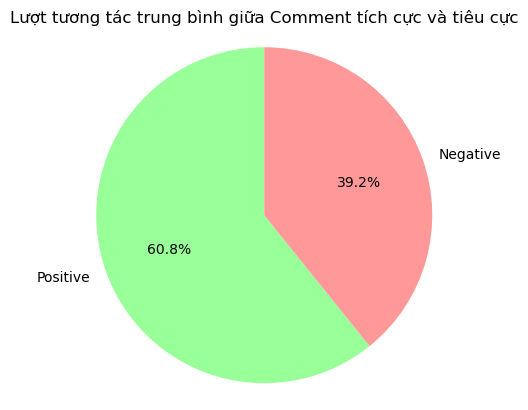

In [241]:
positive_mean = read_df[read_df['POSITIVE'] > read_df['NEGATIVE']]['total_reactions'].mean()
negative_mean = read_df[read_df['POSITIVE'] < read_df['NEGATIVE']]['total_reactions'].mean()

sizes = [positive_mean, negative_mean]
labels = ['Positive', 'Negative']
colors = ['#99ff99', '#ff9999']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

plt.title('Lượt tương tác trung bình giữa Comment tích cực và tiêu cực')

plt.axis('equal')

plt.show()